Question 1

(1) Use Bayes rule to write down your own classifier
$$
h(x) = argmin_{k \in \{0, 1\}} p(C_k | x)
$$

$$
P(C_k | x) = \frac{P(C_k, | x}{P(x)} = \frac{c * g((x - \mu_k)^T \Sigma^{-1} (x - \mu_k)}{2 * P(x)}
$$

Define C = $\frac{c}{2 * P(x)}$, q = P(C_1 | x) - P(C_0 | x)

$$
\ln{\frac{P(t = 1 | x)}{P(t = 0 | x)}} = C (g((x - \mu_1)^T \Sigma^{-1} (x - \mu_1)) - g((x - \mu_0)^T \Sigma^{-1} (x - \mu_0)))
$$

As g is monotonically increasing, then q > 0 if and only if:

$$
(x - \mu_1)^T \Sigma^{-1}(x - \mu_1) > (x - \mu_0)^T \Sigma^{-1}(x - \mu_0)  \\
(x - \mu_1)^T \Sigma^{-1}(x - \mu_1) - (x - \mu_0)^T \Sigma^{-1}(x - \mu_0) > 0 \\
x^T \Sigma^{-1} x - \mu_1^T \Sigma^{-1} x - x^T \Sigma^{-1} \mu_1 + \mu_1^T \Sigma^{-1} \mu_1 - x^T \Sigma^{-1} x + \mu_0^T \Sigma^{-1} x - x^T \Sigma^{-1} \mu_0 + \mu_0^T \Sigma^{-1} \mu_0 > 0 \\
(\mu_0 - \mu_1)^T \Sigma^{-1} x + x^T \Sigma^{-1} (\mu_0 - \mu_1) + \mu_1^T \Sigma^{-1} \mu_1 - \mu_0 \Sigma^{-1} \mu_0 > 0 \\
2x^T \Sigma^{-1} (\mu_0 - \mu_1) + \mu_1^T \Sigma^{-1} \mu_1 - \mu_0 \Sigma^{-1} \mu_0 > 0\\
$$

(2) Show that the Bayes’ classifier is a linear classifier and give its explicit form.


Let w = $2x^T \Sigma^{-1} (\mu_0 - \mu_1)$, $w_0 = \mu_1^T \Sigma^{-1} \mu_1 - \mu_0 \Sigma^{-1} \mu_0$

$$
B = x^T w + w_0 
$$

$$
h(x) = \left\{\begin{array}{ll}
{1} & { B > 0 } \\
{0} & { B < 0 }
\end{array}\right.
$$

This is a linear classifier.

In [2]:
import numpy as np
import torch
from torch.autograd import Variable, grad
import torch.nn.functional as F
import timeit

In [3]:
#Question 2

class NN_Classification():      
    def __init__(self, X, Y, layers):
        if torch.cuda.is_available() == True:
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor
        
        self.jitter = 1e-8
        
        X = torch.from_numpy(X).type(self.dtype)
        Y = torch.from_numpy(Y).type(self.dtype)
                
        self.Xmean, self.Xstd = X.mean(0), X.std(0)
        self.X = (X - self.Xmean) / (self.Xstd + self.jitter)
        self.Y = Y

        self.layers = layers
        
        self.weights, self.biases = self.initialize_NN(self.layers)        
        self.optimizer = torch.optim.Adam(list(self.weights) + list(self.biases), lr = 1e-3)   
        
        
    def initialize_NN(self, layers):      
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return Variable(xavier_stddev*torch.randn(in_dim, out_dim).type(self.dtype), requires_grad=True)
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = Variable(torch.zeros(1,layers[l+1]).type(self.dtype), requires_grad=True)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    

    def forward_pass(self, H):
        num_layers = len(self.layers)
        for l in range(0,num_layers-2):
            W = self.weights[l]
            b = self.biases[l]
            H = F.relu(torch.add(torch.matmul(H, W), b))

        W = self.weights[-1]
        b = self.biases[-1]
        H = torch.add(torch.matmul(H, W), b)
        H = F.sigmoid(H)
        return H
    

    def fetch_minibatch(self,X, Y, N_batch):
        N = X.shape[0]
        idx = np.random.choice(N, N_batch, replace=False)
        X_batch = X[idx,:]
        Y_batch = Y[idx,:]        
        return X_batch, Y_batch
            

    def compute_loss(self, X_batch, Y_batch):
        Y_pred = self.forward_pass(X_batch)
        loss = - Y_batch * torch.log(Y_pred + self.jitter) - (1 - Y_batch)*torch.log(1 - Y_pred + self.jitter)           
        return torch.mean(loss)
    

    def train(self, nIter = 10000, batch_size = 100):   
        start_time = timeit.default_timer()            
        for it in range(nIter):
            X_batch, Y_batch = self.fetch_minibatch(self.X, self.Y, batch_size)

#            print("ref", Y_batch.flatten())
#            here = self.predict(X_batch)
#            print("here", here.flatten())

            self.optimizer.zero_grad()
            loss_train = self.compute_loss(X_batch, Y_batch)   
            loss_train.backward()            
            self.optimizer.step()
            
            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_train, elapsed))
                start_time = timeit.default_timer()

        
    def predict(self, X_star): 
        X_star = torch.from_numpy(X_star).type(self.dtype)
        X_star = (X_star - self.Xmean) / (self.Xstd + self.jitter)           
        Y_star = self.forward_pass(X_star)
        Y_star = Y_star.cpu().data.numpy()
        return Y_star

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from models import NN_Classification

from plotting import newfig, savefig


if __name__ == "__main__":
    here = np.load("Data.npy", allow_pickle = True).item()
    X = here["X"]
    y = here["Y"]
    N = len(X)

    idx = np.random.choice(N, N, replace=False)
    X = X[idx,:]
    y = y[idx,:]

    X_train, y_train = X[:N*3//4,:], y[:N*3//4,:]
    X_test, y_test = X[N*3//4:,:], y[N*3//4:,:]

    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    layers = [10, 20, 20, 1]

    # Model creation
    model1 = NN_Classification(X_train, y_train, layers)
    model1.train(nIter = 10000)

    y_pred = model1.predict(X_test)
    #print(y_pred[0:50].flatten())

    N_test = y_pred.shape[0]
    for i in range(N_test):
        if y_pred[i] >= 0.5:
            y_pred[i] = 1.0
        else:
            y_pred[i] = 0.0

    #print(y_test[0:50].flatten())
    #print(y_pred[0:50].flatten())
    accuracy = np.sum(y_test == y_pred) / N_test
    print(accuracy)


(2601, 10)
(2601, 1)
(868, 10)
(868, 1)
It: 0, Loss: 7.093e-01, Time: 0.03
It: 100, Loss: 4.627e-01, Time: 0.12


/home/tkar/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


It: 200, Loss: 4.296e-01, Time: 0.09
It: 300, Loss: 3.702e-01, Time: 0.08
It: 400, Loss: 3.439e-01, Time: 0.08
It: 500, Loss: 3.615e-01, Time: 0.08
It: 600, Loss: 3.613e-01, Time: 0.07
It: 700, Loss: 3.405e-01, Time: 0.08
It: 800, Loss: 3.789e-01, Time: 0.08
It: 900, Loss: 3.808e-01, Time: 0.08
It: 1000, Loss: 4.191e-01, Time: 0.11
It: 1100, Loss: 2.737e-01, Time: 0.12
It: 1200, Loss: 2.900e-01, Time: 0.11
It: 1300, Loss: 4.097e-01, Time: 0.08
It: 1400, Loss: 3.636e-01, Time: 0.09
It: 1500, Loss: 2.313e-01, Time: 0.07
It: 1600, Loss: 3.300e-01, Time: 0.07
It: 1700, Loss: 3.328e-01, Time: 0.07
It: 1800, Loss: 3.927e-01, Time: 0.08
It: 1900, Loss: 3.139e-01, Time: 0.07
It: 2000, Loss: 3.865e-01, Time: 0.08
It: 2100, Loss: 2.329e-01, Time: 0.08
It: 2200, Loss: 3.808e-01, Time: 0.07
It: 2300, Loss: 2.952e-01, Time: 0.07
It: 2400, Loss: 3.198e-01, Time: 0.08
It: 2500, Loss: 3.041e-01, Time: 0.07
It: 2600, Loss: 2.629e-01, Time: 0.07
It: 2700, Loss: 2.926e-01, Time: 0.08
It: 2800, Loss: 2.43

A prediction accuracy of around 80% can be achieved with a 25% test split.

In [11]:
#Question 3

from pyDOE import lhs
import matplotlib.pyplot as plt

In [20]:
#N = 100

N = 100
X = 4 * lhs(1, N) + 50 #Making the domain of X as [50, 54]
Y = 4 * lhs(1, N) + 50
Z = np.cos(np.pi * X) * np.cos(np.pi * Y)
Z = torch.from_numpy(Z)

Q = 50
d = 2
r = 1
w1 = np.ones((d, 1))
w2 = np.ones((Q, 1))
w3 = np.ones((Q, 1))

w1 = w1 * np.random.multivariate_normal([0], [[2/(d + Q)]], Q).T
w2 = w2 * np.random.multivariate_normal([0], [[2/(Q + Q)]], Q).T
w3 = w3 * np.random.multivariate_normal([0], [[2/(Q + r)]], r).T

b1 = np.zeros((1,Q))
b2 = np.zeros((1,Q))
b3 = np.zeros((1,r))

w1 = torch.from_numpy(w1)
w2 = torch.from_numpy(w2)
w3 = torch.from_numpy(w3)
b1 = torch.from_numpy(b1)
b2 = torch.from_numpy(b2)
b3 = torch.from_numpy(b3)

w1 = Variable(w1, requires_grad = True)
w2 = Variable(w2, requires_grad = True)
w3 = Variable(w3, requires_grad = True)
b1 = Variable(b1, requires_grad = True)
b2 = Variable(b2, requires_grad = True)
b3 = Variable(b3, requires_grad = True)

#Xavier Initialization
mean_X = np.mean(X)
std_X = np.std(X)
mean_Y = np.mean(Y)
std_Y = np.std(Y)

#X = (X - mean_X) / std_X
#Y = (Y - mean_Y) / std_Y

phi = np.concatenate(((X - mean_X) / std_X, (Y - mean_Y) / std_Y), axis=1)
phi = torch.from_numpy(phi)

In [21]:
loss_fn = torch.nn.MSELoss(reduction='sum')

var_list = [w1, w2, w3, b1, b2, b3]
optimizer = torch.optim.Adam(var_list, lr = .0001)

iter_count = 20000
losses = []

for i in range(iter_count):
    Z_pred = torch.matmul(torch.tanh(torch.matmul(torch.tanh(torch.matmul(phi, w1) + b1), w2) + b2), w3) + b3
    loss = loss_fn(Z_pred, Z)
    optimizer.zero_grad()
    loss.backward()
    print(loss.item())
    losses.append(loss.item())
    optimizer.step()

58.70012256717937
54.853922208920466
51.2768014387711
47.97054672929484
44.935666803144244
42.17126032651254
39.67488737771942
37.442449304623835
35.46808268084801
33.74407423386331
32.260804770072774
31.006731130885996
29.968415867316754
29.130614319261245
28.476427768548533
27.987528949529302
27.644462210784454
27.427015032324555
27.31465077289307
27.28698520972099
27.324282733984315
27.407943222066258
27.52094871498618
27.64824075267413
27.77700449994387
27.89684392779244
27.99984199187319
28.08050947027952
28.135634515488483
28.164051095442165
28.16634795347842
28.14454062719365
28.10172791360285
28.04175160005621
27.968874942269014
27.88749179360522
27.80187484295814
27.7159683121454
27.63322777940046
27.556507529457054
27.487993934813133
27.42918178795674
27.380889183051337
27.343305463462737
27.3160659098027
27.298346263606142
27.288969896484375
27.286520473550798
27.289453338558488
27.29619955791386
27.305257563918097
27.315268568193478
27.325073285691214
27.333748916724645
27.

27.286371647093574
27.286371274540503
27.286370901483693
27.286370527922934
27.286370153857963
27.2863697792886
27.286369404214607
27.286369028635747
27.286368652551833
27.286368275962616
27.286367898867887
27.28636752126741
27.286367143160938
27.28636676454828
27.286366385429194
27.286366005803426
27.286365625670765
27.286365245030986
27.286364863883826
27.286364482229065
27.286364100066486
27.28636371739583
27.28636333421686
27.286362950529334
27.286362566333036
27.286362181627698
27.28636179641309
27.286361410688954
27.286361024455083
27.286360637711173
27.286360250457033
27.286359862692375
27.286359474416972
27.286359085630558
27.286358696332897
27.286358306523738
27.286357916202817
27.286357525369887
27.286357134024694
27.286356742166966
27.28635634979646
27.286355956912903
27.286355563516064
27.28635516960567
27.286354775181437
27.286354380243115
27.28635398479048
27.28635358882319
27.286353192341053
27.28635279534376
27.286352397831056
27.286351999802655
27.286351601258314
27.28

27.28607997169393
27.286079258723625
27.286078544960173
27.286077830402597
27.286077115050066
27.286076398901663
27.28607568195642
27.286074964213466
27.28607424567189
27.286073526330753
27.286072806189125
27.286072085246154
27.28607136350086
27.28607064095234
27.286069917599626
27.28606919344184
27.28606846847803
27.28606774270727
27.286067016128627
27.28606628874115
27.286065560543918
27.286064831535974
27.286064101716402
27.286063371084236
27.28606263963851
27.286061907378325
27.286061174302713
27.286060440410715
27.286059705701376
27.286058970173723
27.286058233826843
27.28605749665972
27.286056758671453
27.286056019861018
27.286055280227473
27.286054539769864
27.28605379848721
27.28605305637854
27.286052313442877
27.286051569679238
27.28605082508665
27.286050079664143
27.28604933341073
27.286048586325396
27.286047838407185
27.2860470896551
27.286046340068157
27.286045589645354
27.286044838385695
27.28604408628819
27.286043333351824
27.2860425795756
27.286041824958506
27.2860410694

27.260068743366826
27.259825928634843
27.25958215800238
27.259337346317853
27.259091538482036
27.258844689942478
27.258596807237495
27.258347881228985
27.258097895158446
27.257846870620384
27.257594769913375
27.257341655444044
27.25708745570847
27.256832333387273
27.256576102771678
27.256319230350904
27.25606099890759
27.25580239662324
27.255542029205248
27.25528104184284
27.255018974421777
27.254756049431073
27.254492229286242
27.25422720692487
27.253961312973555
27.253694019109084
27.253425841660597
27.253156620157025
27.252886435689927
27.25261529216423
27.252343008464695
27.25206980763163
27.251795388410862
27.25152006212091
27.25124365922502
27.25096630464819
27.25068796066926
27.25040861412616
27.25012833309179
27.249847018027207
27.24956486548901
27.249281656019257
27.24899771273879
27.248712692608578
27.248427002168132
27.24814024341789
27.24785281491775
27.24756438015945
27.24727523516519
27.246985164657964
27.246694342620376
27.24640265302486
27.246110194238213
27.24581690805

26.367834621974815
26.36563219974535
26.363443715493716
26.36126766253552
26.359097202601664
26.356935765813905
26.354783113977106
26.352635277972283
26.350493906226806
26.348360483186653
26.346233695092177
26.344113939889404
26.34200234468552
26.33989894893227
26.337803365172224
26.335715280925747
26.333635549453966
26.331563635314243
26.32949803562571
26.32743971244896
26.32538837708527
26.323343169842015
26.321304537474933
26.319271637368008
26.317245361277408
26.315225576482355
26.31321178145265
26.311204608901694
26.309202863651365
26.307207448343178
26.30521711882555
26.303232461582677
26.301252541727578
26.299277649960793
26.297307213226045
26.295341382102553
26.29337977183538
26.291422465136204
26.289469045966168
26.287519641270066
26.285573612104734
26.28363173420843
26.281692983953604
26.279763368010215
26.277838179152244
26.275941461944665
26.2740409319143
26.27213642141501
26.270215692048247
26.26831433888091
26.26644386646562
26.264585245369584
26.262723590167496
26.260842

25.90048014641129
25.900060340334214
25.89964762266088
25.89922471006085
25.89873301976647
25.898174406282205
25.89758752776706
25.897063098568964
25.89662869998594
25.89623526477475
25.89581095951727
25.895316502931028
25.89479328994572
25.894303712383504
25.893870177939263
25.893455487802914
25.89301005455944
25.892528110674025
25.892042612509858
25.891587780922286
25.89115931586095
25.89072662860551
25.89027121633287
25.889802218875584
25.889343763937045
25.888904633331308
25.888472345742745
25.888030774876203
25.887577035671054
25.88712294211695
25.886678903308155
25.88624375281739
25.885808226283842
25.88536581181106
25.88491918744016
25.884475222826456
25.88403756367183
25.883603527206642
25.883168009595337
25.88272905071196
25.882288829193115
25.88185095303123
25.88141660839136
25.880984013600465
25.88055069378942
25.88011575839375
25.879680483912253
25.879246589781502
25.878814722505023
25.878384084324885
25.877953389330436
25.877522092182794
25.87709056812446
25.87665970129865

25.63929468031723
25.638488438719595
25.637679394720667
25.63686755062245
25.636052909021913
25.635235472725203
25.634415244582765
25.633592227547148
25.63276642482899
25.631937839782594
25.631106475806515
25.630272336456237
25.629435425455316
25.62859574666326
25.627753304019176
25.626908101560026
25.62606014351656
25.62520943419887
25.624355977988046
25.62349977942359
25.6226408431273
25.621779173833815
25.62091477636913
25.62004765562466
25.6191778166471
25.618305264539583
25.617430004469018
25.61655204173224
25.615671381672456
25.614788029737166
25.61390199144931
25.613013272371315
25.61212187818976
25.611227814630766
25.610331087482407
25.609431702629077
25.60852966597898
25.607624983533
25.606717661342604
25.605807705492893
25.604895122164603
25.60397991755764
25.603062097931986
25.60214166960916
25.601218638927154
25.60029301230291
25.59936479617612
25.598433997021083
25.59750062137475
25.59656467578172
25.59562616684447
25.594685101192482
25.593741485471654
25.592795326383136
2

25.055885917028622
25.0543761288744
25.05286620912984
25.051356168764524
25.049846018731177
25.04833577006819
25.046825433740437
25.04531502081275
25.043804542294236
25.042294009236052
25.040783432700806
25.03927282372087
25.037762193392815
25.03625155274884
25.034740912885326
25.033230284854447
25.03171967972549
25.030209108571892
25.028698582432163
25.027188112383936
25.025677709446366
25.024167384674573
25.02265714907956
25.02114701367427
25.01963698946053
25.018127087403386
25.016617318481764
25.01510769361823
25.013598223748534
25.012088919758302
25.01057979252361
25.00907085289184
25.007562111671866
25.006053579662307
25.004545267605128
25.00303718623517
25.00152934622926
25.00002175824411
24.99851443289006
24.997007380736598
24.995500612320363
24.993994138119998
24.99248796858738
24.990982114109272
24.989476585040627
24.987971391674666
24.986466544259763
24.984962052990834
24.983457928003418
24.981954179386253
24.980450817158708
24.9789478512939
24.977445291692398
24.97594314820

24.211863203098275
24.210422347856987
24.208979972521476
24.207536066645027
24.206090619683106
24.204643620702733
24.203195058389383
24.20174492140082
24.200293197866394
24.198839875998775
24.19738494346256
24.195928387915295
24.194470196502824
24.19301035624119
24.19154885368722
24.190085675158574
24.188620806587473
24.187154233576077
24.185685941379898
24.184215914895365
24.182744138636505
24.181270596771583
24.1797952730204
24.178318150770306
24.1768392128765
24.175358441895217
24.173875819721918
24.172391328018385
24.170904947620777
24.169416659212516
24.16792644244653
24.166434276953147
24.164940141026797
24.163444013195633
24.161945870175575
24.16044568939986
24.158943445749166
24.157439115768657
24.15593267226056
24.15442409167795
24.152913344850912
24.151400410671947
24.14988525984075
24.148367881747266
24.146848255993238
24.14532640932963
24.14380236828813
24.14227629209663
24.140748410173135
24.13921937247839
24.13769025716433
24.13616362713947
24.134644119412787
24.133141992

23.34673449248602
23.344437100009426
23.342134587552973
23.339827487177267
23.337516364280727
23.33520124484768
23.332881690653647
23.330557299376668
23.328228079151163
23.325894325161297
23.323556284825603
23.32121392050599
23.31886699282378
23.31651530855321
23.31415885958455
23.311797788693667
23.309432211627467
23.307062122162026
23.304687408489322
23.30230795284298
23.299923723707025
23.297534761343304
23.295141127679344
23.292742837655414
23.29033984945259
23.287932098234034
23.28551953452079
23.283102151069162
23.280679963009415
23.27825298627873
23.275821214537498
23.273384619033937
23.27094316339704
23.268496818089297
23.26604557028159
23.263589416156922
23.26112835497239
23.25866237795357
23.256191467470718
23.253715600747007
23.251234754737137
23.248748911605162
23.24625805779739
23.24376218362913
23.241261278415696
23.238755329234678
23.236244320229645
23.23372823346231
23.231207050870335
23.228680755452505
23.226149331976394
23.223612766143567
23.221071044414458
23.2185241

21.760048224725782
21.754394438076307
21.75028599298761
21.745669531937555
21.739903630873947
21.734775874843653
21.730463047557436
21.72545728866131
21.71993437023511
21.715093503494383
21.71051207597175
21.70531749886373
21.700048031954598
21.695280997030274
21.69045899224839
21.68523467681877
21.680133424469133
21.675325939240526
21.67034222152703
21.665148549101847
21.660136461812947
21.655242068549118
21.650164769061224
21.645021390242714
21.640027373277707
21.635045077279713
21.62992758737953
21.624815838400213
21.6198014650509
21.61475017064318
21.60961507337693
21.604514445349142
21.599461848392615
21.59436018591987
21.589216368622314
21.584106613852228
21.57901267191918
21.57387561783946
21.56871994901842
21.563589862158764
21.558457602003653
21.55329194064184
21.5481206480786
21.54296412729411
21.53779702878676
21.532606720261757
21.527415176520407
21.522229746569714
21.517031582663133
21.511817111349714
21.50660222658282
21.501387639256883
21.49616040838398
21.49092162791713

19.062781209098326
19.05653485085417
19.05028821045838
19.04404278184659
19.03779768959627
19.031551694401628
19.025305305092754
19.019059674994004
19.012814594999075
19.00656912354326
19.000323340562108
18.994078011237434
18.98783327661351
18.981588590411285
18.97534373751041
18.969099175813252
18.96285519163244
18.956611531524196
18.950367947765756
18.94412459164978
18.937881763878607
18.93163944100719
18.925397412153682
18.9191556842215
18.912914436865154
18.906673777479227
18.900433620028075
18.89419387707157
18.887954641346195
18.88171602497105
18.87547804240561
18.86924064095402
18.86300380927764
18.85676763692289
18.8505321832227
18.84429744054304
18.838063393972277
18.83183006156916
18.82559751036858
18.81936577486807
18.813134851236697
18.806904746590597
18.80067548621415
18.794447118717933
18.788219669951843
18.781993145171796
18.775767560741116
18.76954294137101
18.763319325399184
18.757096736173377
18.750875185962062
18.744654694987634
18.738435285681543
18.732216990644716


16.224452488724356
16.221193185489668
16.217938800568533
16.214689429552866
16.2114452147572
16.20820637226552
16.204973055766505
16.20174539409417
16.198523427075614
16.195307151113607
16.192096513954358
16.188891443025184
16.185691868503834
16.18249771950428
16.179308957240405
16.176125542414667
16.17294747350846
16.169774738368098
16.166607356349704
16.16344532654798
16.160288671846068
16.15713739084127
16.153991500582542
16.15085099495812
16.147715883428877
16.144586155875075
16.14146181612169
16.138342852295427
16.135229265147004
16.13212104284443
16.129018185095884
16.125920681054076
16.12282853064037
16.11974172436406
16.116660263343203
16.11358413972583
16.110513357062395
16.107447909999042
16.10438780674508
16.101333046746767
16.098283647582
16.095239619214485
16.09220099889224
16.089167820844057
16.086140165502318
16.083118124483192
16.080101877049348
16.0770916534423
16.074087867614338
16.071091091204835
16.068102313796025
16.06512296178126
16.06215547102248
16.0592034216616

15.06718915870251
15.065973640125918
15.06475931178141
15.063546172919175
15.062334221879892
15.0611234572674
15.059913876393388
15.058705475986905
15.057498252601716
15.056292202416909
15.055087322627598
15.053883610133761
15.052681062999264
15.05147967871812
15.050279455354096
15.049080390329982
15.047882481099421
15.046685724865888
15.045490118639297
15.044295659725767
15.043102345145254
15.041910172504652
15.040719139035698
15.039529242507715
15.038340480280231
15.037152850032458
15.035966349143752
15.034780975087314
15.033596725263408
15.032413596999755
15.031231587774014
15.030050694879083
15.02887091589183
15.027692248135619
15.026514689241889
15.025338236579252
15.024162887765383
15.02298864020638
15.021815491463682
15.020643438978487
15.019472480247629
15.01830261275348
15.017133833944868
15.015966141345567
15.014799532379852
15.013634004604416
15.012469555435716
15.01130618244774
15.010143883060353
15.008982654846848
15.00782249523713
15.006663401791386
15.005505371952607
15.

14.524851744874832
14.523879175437616
14.522906381760444
14.521933379732427
14.520960177424046
14.519986779367
14.519013196650612
14.518039443097216
14.517065538659974
14.516091499785603
14.515117340149096
14.514143071261435
14.513168703505691
14.512194251999313
14.511219732110998
14.510245162034574
14.509270557562296
14.50829593331143
14.507321303568379
14.506346681905274
14.505372084882543
14.504397528437158
14.50342303017951
14.502448606325329
14.501474272637033
14.500500044947865
14.499525938479653
14.498551970220587
14.497578156397017
14.496604514426423
14.495631060802493
14.494657811921412
14.493684784205037
14.492711993525946
14.49173945675561
14.490767190070605
14.48979521047867
14.488823534273402
14.487852177837082
14.486881157377463
14.48591048868066
14.484940188011512
14.483970271004525
14.483000753831044
14.482031652037305
14.481062981300445
14.48009475695241
14.479126994045494
14.478159707701119
14.477192912508496
14.476226623314655
14.475260854368637
14.474295620020454
14

14.015417554758711
14.014589621646614
14.013761505529933
14.012933204835894
14.012104717976051
14.011276043346237
14.010447179326471
14.009618124280998
14.008788876558153
14.007959434490342
14.007129796394135
14.006299960570095
14.005469925302876
14.00463968886117
14.003809249497762
14.002978605449504
14.0021477549374
14.001316696166601
14.000485427326439
13.999653946590584
13.998822252117012
13.997990342048146
13.997158214510979
13.996325867617088
13.995493299462868
13.99466050812964
13.993827491683724
13.992994248176739
13.992160775645697
13.991327072113243
13.990493135587826
13.989658964064004
13.988824555522633
13.98798990793116
13.987155019243929
13.986319887402429
13.985484510335715
13.984648885960652
13.983813012182376
13.982976886894608
13.982140507980114
13.981303873311129
13.980466980749776
13.979629828148617
13.978792413351115
13.97795473419211
13.977116788498522
13.976278574089765
13.975440088778427
13.974601330370977
13.973762296668237
13.972922985466242
13.972083394556883

13.574972493619377
13.572520352969901
13.57071053171291
13.571127018617291
13.57082076518933
13.568929279182699
13.567674956425481
13.567522101325828
13.567008852509321
13.565664435924019
13.564464354106384
13.564046872925191
13.56357085468821
13.562346875394628
13.561238919399457
13.560785026829604
13.560164370873933
13.559060024403118
13.558120475963158
13.557515516194744
13.556817610259937
13.555883781971483
13.554968310554942
13.554258774312629
13.553580044310191
13.552704344099267
13.551795131672112
13.551069882336376
13.550365362120859
13.549514305705205
13.548653680265618
13.5478961680418
13.54715517100026
13.54634971470609
13.54551380599713
13.54472157256176
13.543972889846378
13.543190477921264
13.542362771464548
13.541564217670103
13.540805076492452
13.54002464418289
13.539215099418762
13.538416736883878
13.53763961113086
13.53686244241164
13.53606910388159
13.535268288277619
13.534481327312292
13.533705419898808
13.532918240258802
13.532120396467647
13.531330540340141
13.530

13.2346199926869
13.233895987586362
13.233172029546411
13.232448118674379
13.231724255007382
13.231000438660379
13.230276669666345
13.229552948154833
13.228829274156716
13.228105647831187
13.227382069215782
13.226658538531728
13.22593505585347
13.225211621541717
13.224488235799699
13.223764899327909
13.22304161273525
13.222318377611666
13.221595195815313
13.220872071422589
13.220149010166143
13.2194260234861
13.218703129399302
13.217980362289284
13.217257780290343
13.216535492623546
13.21581369287812
13.215092744914534
13.214373315936975
13.213656671035602
13.212945192079468
13.212243450993444
13.211560239536281
13.210912623470714
13.210333881448982
13.209888685008595
13.209702350231614
13.2100088543606
13.211224007977684
13.213961537283563
13.218807202754528
13.225111210967686
13.229260394612535
13.225010212758121
13.212647238619002
13.202824120230572
13.204107871368395
13.211026172794815
13.21201820136647
13.204773364138594
13.198891600167247
13.200864221066867
13.204580798054653
13.

12.896330574199386
12.895722719444144
12.895114885385933
12.894507071979945
12.893899279195605
12.893291506987662
12.89268375533456
12.892076024193608
12.891468313564323
12.89086062341935
12.890252953814281
12.889645304784434
12.88903767655032
12.88843006938197
12.887822484026916
12.887214921616772
12.88660738469497
12.885999877583227
12.885392409273326
12.884784996151327
12.88417767141289
12.883570498338484
12.882963604630806
12.88235724146442
12.881751919268568
12.88114866607433
12.880549596404007
12.879959051261425
12.87938608527391
12.878849564739905
12.878389330759841
12.878088855454708
12.878124369392392
12.878854576420053
12.880990058432866
12.88571574269104
12.894463838419925
12.906373597430116
12.914095370474156
12.904503310546314
12.88209079174313
12.871665630014851
12.881909466971715
12.891537580403652
12.882795370768921
12.87008089670609
12.872846414778033
12.880836789049518
12.876476879799926
12.867599738110124
12.869441993042452
12.874398001934338
12.870343586061683
12.86

12.588042553200863
12.587540152638795
12.58703774955891
12.586535343882034
12.586032935523962
12.58553052440772
12.585028110448038
12.584525693568814
12.584023273685037
12.583520850719832
12.583018424589243
12.58251599521451
12.58201356251308
12.581511126404093
12.5810086868065
12.580506243637629
12.580003796817536
12.57950134626246
12.57899889189308
12.578496433625
12.57799397137909
12.577491505070693
12.576989034620489
12.576486559943831
12.575984080960934
12.575481597587343
12.574979109742696
12.574476617342759
12.573974120306596
12.573471618550228
12.572969111992125
12.57246660054846
12.571964084137285
12.571461562674871
12.570959036078845
12.570456504265502
12.569953967152136
12.569451424655014
12.568948876691183
12.568446323176765
12.567943764028637
12.567441199162733
12.566938628495796
12.566436051943514
12.565933469422607
12.56543088084838
12.564928286137617
12.564425685205203
12.56392307796807
12.563420464340572
12.562917844239973
12.562415217579888
12.561912584278256
12.56140

12.384613280543661
12.379313070836222
12.375370716134412
12.37907931984636
12.379591061636429
12.374895468005077
12.37441575302144
12.376952107754345
12.375189726209223
12.372355593695987
12.373406513225518
12.374129740275505
12.37183356020841
12.37079949753277
12.371838114492315
12.37122124328681
12.369469360788615
12.369435107755999
12.36980415046141
12.36867469957946
12.367689513130825
12.367889172599437
12.367629812816528
12.366554953213054
12.36610047868047
12.366136011952706
12.36553795539017
12.3647266913289
12.364492381214953
12.36428160859131
12.363602414078384
12.363029650321046
12.36281321851937
12.362425821260135
12.361794534212786
12.361362446538692
12.361084186619708
12.360612006038979
12.360060353686249
12.359684407391482
12.35933773170848
12.358844492818466
12.358357632404898
12.357989444003799
12.357595089253115
12.357110331399836
12.356663227016794
12.356283674101357
12.355863468513412
12.355395458692476
12.354967942737016
12.354573768309503
12.354142736257655
12.3536

12.152728487134972
12.152307324779752
12.151886062850041
12.151464701160714
12.151043239639488
12.150621678197556
12.15020001674951
12.149778255157829
12.149356393251693
12.148934430908248
12.148512367999574
12.148090204446008
12.147667940133699
12.147245574934075
12.14682310871575
12.146400541333374
12.14597787268347
12.145555102645801
12.145132231116973
12.1447092579749
12.144286183087749
12.143863006335813
12.143439727586994
12.14301634673542
12.142592863659797
12.142169278246921
12.14174559037575
12.141321799918614
12.140897906759706
12.140473910772398
12.140049811846652
12.139625609860849
12.139201304699286
12.138776896242652
12.138352384367513
12.137927768958553
12.137503049891722
12.137078227054564
12.136653300325937
12.136228269590495
12.135803134729542
12.135377895623034
12.134952552155195
12.134527104204425
12.134101551656943
12.13367589439233
12.133250132296013
12.132824265249612
12.13239829313583
12.131972215838397
12.131546033238193
12.131119745220747
12.130693351666846
12

11.96947415543113
11.969041775237113
11.968609265050775
11.968176624514143
11.967743853261641
11.967310950922474
11.966877917117962
11.966444751463936
11.96601145356821
11.965578023032757
11.965144459451475
11.964710762411949
11.964276931493709
11.963842966269503
11.963408866303967
11.96297463115457
11.96254026037047
11.962105753493333
11.96167111005645
11.961236329585113
11.960801411596092
11.9603663555979
11.959931161090177
11.959495827564012
11.959060354501512
11.958624741375743
11.958188987650534
11.957753092780417
11.957317056210407
11.956880877375868
11.956444555702294
11.956008090605271
11.955571481490194
11.95513472775217
11.954697828775817
11.954260783935156
11.953823592593288
11.953386254102446
11.952948767803507
11.952511133026228
11.952073349088561
11.951635415297035
11.951197330945874
11.950759095317649
11.95032070768209
11.94988216729707
11.949443473406934
11.949004625244138
11.948565622026699
11.948126462961048
11.947687147237808
11.947247674036822
11.946808042520113
11.

11.67654367454177
11.676028817530474
11.67551359991155
11.674998091080884
11.67448385945885
11.673970590742414
11.67345707846912
11.67294376220192
11.672431563384109
11.671919989235962
11.671408366827672
11.670897196726882
11.670386951166211
11.669877176506118
11.669367550989177
11.668858469871651
11.668350162462076
11.667842289124106
11.667334693981328
11.666827672797362
11.666321325803672
11.665815411480166
11.665309869335003
11.664804893868421
11.664300530589276
11.663796622124245
11.663293136013296
11.662790205915613
11.66228785323201
11.661785971889215
11.66128454891103
11.660783667326399
11.660283341665249
11.659783505778325
11.65928414551712
11.65878531720903
11.658287032530273
11.65778924746209
11.657291952130956
11.656795179457687
11.65629894127834
11.655803211514288
11.655307977584329
11.6548132609473
11.654319071897792
11.65382539431288
11.653332218378006
11.652839554137502
11.652347411245529
11.651855781589516
11.651364655173559
11.650874037189437
11.65038393446922
11.64989

11.479948686740974
11.479591174122232
11.479233688724733
11.478876226973505
11.478518787871655
11.47816137349779
11.47780398510801
11.477446621171778
11.477089279651022
11.476731960513867
11.476374665005308
11.476017393329977
11.475660144211654
11.47530291653378
11.474945710434595
11.47458852651407
11.474231364591658
11.47387422374444
11.473517103308389
11.473160003342231
11.472802924061744
11.472445865189757
11.47208882606939
11.471731806236981
11.471374805636925
11.471017824279077
11.470660861886893
11.470303917974041
11.469946992163246
11.469590084310257
11.469233194316157
11.468876321926748
11.46851946675992
11.468162628480403
11.467805806886398
11.467449001818588
11.467092213041667
11.466735440238272
11.466378683099675
11.466021941390936
11.465665214915932
11.465308503449458
11.464951806715229
11.464595124426278
11.464238456331826
11.463881802211805
11.463525161843451
11.463168534975686
11.462811921341304
11.462455320685557
11.462098732773912
11.461742157380645
11.4613855942686
11

11.308791379113492
11.30847259175822
11.30815376386244
11.30783489532409
11.307515986041713
11.307197035913482
11.306878044837706
11.30655901271282
11.306239939437079
11.305920824908954
11.305601669026817
11.305282471689221
11.304963232794496
11.304643952241284
11.30432462992805
11.304005265753313
11.303685859615703
11.303366411413732
11.30304692104612
11.302727388411366
11.30240781340828
11.302088195935463
11.301768535891618
11.301448833175465
11.301129087685766
11.300809299321282
11.300489467980757
11.300169593563052
11.299849675966895
11.29952971509121
11.29920971083479
11.298889663096505
11.29856957177528
11.29824943676999
11.297929257979547
11.297609035302887
11.297288768639005
11.29696845788679
11.296648102945271
11.296327703713372
11.296007260090205
11.295686771974689
11.295366239265917
11.295045661862865
11.294725039664637
11.294404372570321
11.294083660478947
11.293762903289622
11.293442100901425
11.29312125321347
11.292800360124899
11.292479421534827
11.292158437342358
11.291

11.1724843928783
11.200559302806017
11.236462587486674
11.252740170049615
11.216699484910814
11.154827273860853
11.141576162907935
11.179199000708408
11.195679561582047
11.16154534847275
11.136988223815452
11.157947055559939
11.17328765951316
11.150950297601936
11.136135504387696
11.152209246127878
11.158294291214178
11.140934373771955
11.136494360928435
11.148832704828356
11.147024126657524
11.135114546753291
11.137611218707972
11.144589984265192
11.138717141094448
11.133046789538145
11.137887490575121
11.139504448096812
11.133668165786455
11.132840925571754
11.136583252083772
11.134897871848285
11.131270697636241
11.132724983089426
11.13419509774924
11.131581061663677
11.130285275204635
11.131921819327134
11.131605930394473
11.129550351783188
11.129639890828484
11.130506803014425
11.129422195774994
11.12831205307713
11.128808634872625
11.128868980900924
11.127768024458216
11.127366650189098
11.127718660880996
11.127303653845653
11.126499036826134
11.126429342864496
11.126486102164847

11.023000625730134
11.01877472652357
11.022124894178916
11.02331491884352
11.019083407766592
11.018353448456507
11.020986441745139
11.01978481034095
11.01708830360797
11.018001820868868
11.019053833603248
11.017171375646996
11.016094388547161
11.017180110890461
11.016991249315153
11.01544659554625
11.015351231703958
11.015950885698212
11.015192709442323
11.01426916210669
11.01450371434609
11.014564246339544
11.013744408485891
11.013309531534565
11.0134943188395
11.013213994110467
11.012556767005016
11.012376352679867
11.0123888356544
11.01197329173052
11.011507213853783
11.011403087214775
11.011260694969199
11.01083689900134
11.010508148805839
11.010389296167514
11.0101517792231
11.009770500864029
11.009515550084087
11.009353934054516
11.009073765127404
11.00874109935327
11.008514838459517
11.008313474666014
11.008022626331062
11.007727054888191
11.007505296833633
11.007276558830787
11.006989652320481
11.006717166069421
11.006490133578676
11.006245706257435
11.005967013283264
11.005706

10.88546659066603
10.885214799305066
10.884963100904846
10.884711445928689
10.884459599242069
10.88420754266063
10.883955462037493
10.883703417551168
10.88345127547235
10.883198952180836
10.882946531239508
10.882694103908348
10.88244162814215
10.882189017980942
10.881936282385196
10.881683491971048
10.881430661893283
10.881177739794223
10.880924696128027
10.88067156388317
10.880418376920197
10.880165120458324
10.879911762137517
10.87965830176061
10.879404765779269
10.87915116334091
10.878897476624077
10.878643691635174
10.878389816690907
10.878135866654603
10.877881840298544
10.877627725066313
10.877373516954872
10.877119223815097
10.876864852445646
10.876610399143509
10.87635585664991
10.87610122487608
10.875846509134334
10.875591712073364
10.875336830432033
10.875081860337223
10.874826802694644
10.874571660644925
10.874316435085886
10.874061123769257
10.873805724632005
10.873550238519563
10.873294667184407
10.873039010902787
10.872783268271357
10.872527438115009
10.87227152098016
10.

10.736515798073777
10.736247104341544
10.735978299131375
10.735709382329455
10.735440353822359
10.735171213495995
10.734901961236712
10.734632596930076
10.734363120462076
10.73409353171817
10.733823830583939
10.733554016944522
10.733284090685284
10.733014051691073
10.732743899846918
10.732473635037438
10.732203257147257
10.731932766060861
10.731662161662477
10.731391443836294
10.731120612466288
10.73084966743637
10.730578608630124
10.730307435931266
10.730036149223086
10.72976474838894
10.72949323331182
10.72922160387488
10.728949859960737
10.728678001452245
10.728406028231733
10.728133940181815
10.727861737184432
10.727589419121914
10.727316985875927
10.727044437328583
10.72677177336104
10.726498993855367
10.726226098692132
10.725953087753389
10.725679960919159
10.725406718071431
10.725133359089615
10.724859883855892
10.724586292248693
10.724312584150876
10.724038759439367
10.723764817998317
10.723490759702711
10.72321658443885
10.722942292078923
10.722667882513552
10.722393355610784


10.584665503281848
10.5844114392592
10.584157648656376
10.58390331823852
10.583648461520283
10.583393738833767
10.583139302903978
10.582884662384854
10.58262956513389
10.582374334035574
10.582119263967272
10.581864177667608
10.581608785416766
10.581353145181739
10.58109750453517
10.580841895179404
10.580586127682654
10.580330113744544
10.5800739781218
10.579817831620362
10.579561612685241
10.579305210905021
10.57904863477574
10.578791977483782
10.578535265178864
10.578278432976006
10.578021435493344
10.577764305672796
10.57750709408755
10.577249793702528
10.576992360835648
10.576734783512473
10.5764770904467
10.57621930437538
10.57596141155763
10.575703387297178
10.575445232049596
10.575186964767777
10.574928594422529
10.574670109621147
10.574411497315943
10.5741527607948
10.573893911260473
10.573634952028367
10.573375875497952
10.573116674718303
10.572857352548558
10.572597915346176
10.572338364460832
10.57207869529047
10.571818903877373
10.571558991995879
10.571298963216199
10.571038

10.42411212422758
10.423456807660028
10.422728684252787
10.422046894354605
10.421494761127338
10.421103373739655
10.42085583749812
10.420703704874581
10.420587376129548
10.420453468323347
10.420265407313721
10.420007582444088
10.419682817693435
10.419307669559721
10.418904893089856
10.418497703660874
10.418104746192459
10.417737876181278
10.417401795047468
10.417095209928558
10.416812848172656
10.416547505132781
10.416291755528027
10.416039186216107
10.41578492825378
10.415525885799807
10.415260498951675
10.414988478600634
10.41471038231047
10.414427298359643
10.414140545297176
10.413851482247377
10.413561394875837
10.413271439070952
10.412982647920392
10.412695965397063
10.412412313962136
10.412132675361308
10.411858201778559
10.41159032550732
10.411330953390397
10.411082615245034
10.410848852597468
10.410634441193913
10.410446193105972
10.410293302040238
10.410189000297615
10.410151000209142
10.410204800111877
10.410383665433347
10.410734660018406
10.411315155064024
10.41220152205754

10.259222112189919
10.258912655266158
10.25860307159091
10.258293375915924
10.257983585348494
10.257673734207996
10.257363868399482
10.25705407254346
10.256744470683365
10.256435282217009
10.256126848980532
10.255819765587377
10.255514998756297
10.255214225687387
10.254920260120732
10.254638008806149
10.254375906689965
10.25414879102171
10.253982660458965
10.253923631901111
10.254053547973669
10.254517831072526
10.255574177477515
10.257670339083784
10.261564522591645
10.268435787042534
10.279870313191747
10.297096444218655
10.318804208621108
10.336939630712024
10.336626245108002
10.308714751902754
10.269199312121836
10.249196038370018
10.26014896211273
10.282650544890727
10.288923655960707
10.271609638069163
10.251149307204244
10.24939583324306
10.262626808352273
10.270056097591265
10.261553588802576
10.24871613237642
10.24696834197088
10.25488773086383
10.259009356705754
10.253294922432511
10.245756987909816
10.245487726745756
10.250366040525117
10.251944163172475
10.247765958571579
1

10.08975524000666
10.090687547501812
10.089923716441946
10.088322883828107
10.08785950589545
10.088431557822776
10.088417784371378
10.08739403322286
10.086529213565298
10.08654116232418
10.08672415031666
10.086264263765578
10.085451155189823
10.085038737215564
10.085059651998304
10.084919487623088
10.084373946755454
10.083809495276077
10.083568035067465
10.083470715667788
10.083172717860746
10.08267970234772
10.082270673965768
10.082055748733719
10.081857053084496
10.081510362996198
10.081086950598761
10.080749898076402
10.08051472098658
10.080257618116603
10.079908996072492
10.079535319331525
10.079223983322303
10.07896377318043
10.078679108506645
10.078341379220394
10.077996580929453
10.0776911816032
10.077412385690721
10.07711620341999
10.076789407124268
10.076459965699208
10.076153835023604
10.075863004888369
10.075562168970327
10.075243296706672
10.074921930459192
10.074613620797214
10.074315129621827
10.074012060302373
10.073698252569349
10.073381376237169
10.07307116182024
10.07

9.916938552602614
9.915051197071433
9.914314464698345
9.915095034965718
9.915101617513248
9.913821460985892
9.91304864046776
9.913383347895484
9.913443532746768
9.912585271117335
9.911844618999284
9.911869149730249
9.911908723263993
9.91133858779393
9.910672407989285
9.91048963094032
9.910465298629076
9.910080348016558
9.909509824364862
9.90920105720453
9.90909286584944
9.908813658763906
9.90834136740195
9.90797056665
9.907778518862726
9.907544272681205
9.907157918527853
9.906772447497273
9.906511202028979
9.906279933975803
9.905956587734371
9.905586675982299
9.905279713333098
9.905027649824008
9.904740220886307
9.904399075225689
9.90407161140299
9.903791816889754
9.903515476621411
9.90320199207525
9.902874338877488
9.902572352325542
9.902290267910598
9.901994177612103
9.901677400996098
9.901364833298068
9.901070493335904
9.900779320007198
9.900474601351494
9.900162296941046
9.899858011926032
9.89956291618356
9.899264927770036
9.898958312162815
9.898650476166479
9.898349017551897
9.898

9.749823615755577
9.749516702597058
9.749209711949476
9.748902643852073
9.748595498339167
9.748288275450623
9.747980975220624
9.74767359768957
9.747366142891304
9.747058610867075
9.746751001650303
9.746443315283077
9.746135551798254
9.74582771123892
9.745519793637284
9.745211799037719
9.744903727471277
9.744595578984262
9.74428735360594
9.743979051385493
9.743670672349479
9.743362216551162
9.743053684013468
9.742745074795813
9.742436388915772
9.742127626442965
9.74181878738769
9.741509871836877
9.74120087979214
9.740891811372258
9.74058266657283
9.740273445576442
9.739964148390944
9.739654775339586
9.739345326514174
9.739035802580712
9.73872620396245
9.73841653223651
9.738106788980186
9.737796978378201
9.737487105877658
9.737177183584103
9.736867229880223
9.736557282114576
9.736247402428416
9.735937711917337
9.735628423667952
9.735319946521985
9.735013026547083
9.734709093158099
9.7344108221752
9.734123371323383
9.7338565835171
9.733629616499437
9.733479579970304
9.733479472371835
9.73

9.574021527206606
9.57375014225378
9.573478710429018
9.573207231792782
9.572935706383243
9.572664134246041
9.572392515424388
9.572120849951665
9.571849137878692
9.571577379237505
9.571305574083658
9.57103372245324
9.570761824398158
9.57048987995903
9.570217889179576
9.569945852105217
9.569673768773958
9.569401639235812
9.569129463527513
9.568857241700966
9.568584973794653
9.568312659858332
9.568040299933655
9.567767894066105
9.567495442300965
9.567222944680081
9.566950401251594
9.566677812055826
9.56640517714242
9.566132496551896
9.565859770333605
9.565586998529492
9.565314181187357
9.56504131835113
9.564768410066481
9.564495456379445
9.564222457334088
9.563949412978022
9.563676323354446
9.563403188511877
9.563130008493353
9.562856783347652
9.562583513118303
9.562310197853591
9.56203683759793
9.561763432398887
9.561489982302021
9.561216487354107
9.560942947601706
9.560669363090822
9.560395733868958
9.560122059981776
9.559848341477313
9.559574578401019
9.559300770801443
9.55902691872395

9.412943869119275
9.41271831046224
9.41249275348086
9.412267112314032
9.412041396550837
9.41181568167673
9.411589999975973
9.411364309084009
9.411138559892201
9.410912757735657
9.410686946191507
9.410461145159903
9.410235331631853
9.410009476421441
9.40978357989981
9.409557666615976
9.409331750432786
9.409105820517292
9.408879859242523
9.408653863742522
9.408427847073797
9.408201819258203
9.407975776644921
9.407749708914073
9.407523611866896
9.407297491566112
9.407071354934974
9.406845202156406
9.406619027799842
9.406392827787437
9.40616660407032
9.405940360878565
9.405714099998466
9.405487819232649
9.405261515503934
9.40503518863959
9.404808840666972
9.404582473557284
9.40435608702136
9.404129679302837
9.403903249486785
9.40367679806467
9.403450326440755
9.403223835153772
9.402997323617406
9.402770791021025
9.402544237068712
9.402317662404892
9.402091067633116
9.401864452889766
9.401637817808128
9.401411161945498
9.40118448538752
9.400957788436905
9.400731071452054
9.400504334448959
9

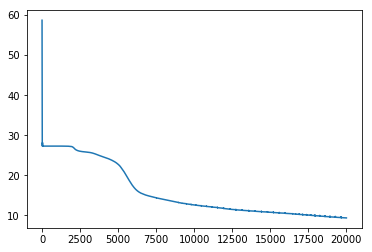

In [22]:
#Number of iterations vs. Loss for N = 100

plt.plot(range(iter_count), losses)

In [13]:
#N = 1000

N = 1000
X = 4 * lhs(1, N) + 50 #Making the domain of X as [50, 54]
Y = 4 * lhs(1, N) + 50
Z = np.cos(np.pi * X) * np.cos(np.pi * Y)
Z = torch.from_numpy(Z)

Q = 50
d = 2
r = 1
w1 = np.ones((d, 1))
w2 = np.ones((Q, 1))
w3 = np.ones((Q, 1))

w1 = w1 * np.random.multivariate_normal([0], [[2/(d + Q)]], Q).T
w2 = w2 * np.random.multivariate_normal([0], [[2/(Q + Q)]], Q).T
w3 = w3 * np.random.multivariate_normal([0], [[2/(Q + r)]], r).T

b1 = np.zeros((1,Q))
b2 = np.zeros((1,Q))
b3 = np.zeros((1,r))

w1 = torch.from_numpy(w1)
w2 = torch.from_numpy(w2)
w3 = torch.from_numpy(w3)
b1 = torch.from_numpy(b1)
b2 = torch.from_numpy(b2)
b3 = torch.from_numpy(b3)

w1 = Variable(w1, requires_grad = True)
w2 = Variable(w2, requires_grad = True)
w3 = Variable(w3, requires_grad = True)
b1 = Variable(b1, requires_grad = True)
b2 = Variable(b2, requires_grad = True)
b3 = Variable(b3, requires_grad = True)

#Xavier Initialization
mean_X = np.mean(X)
std_X = np.std(X)
mean_Y = np.mean(Y)
std_Y = np.std(Y)

#X = (X - mean_X) / std_X
#Y = (Y - mean_Y) / std_Y

phi = np.concatenate(((X - mean_X) / std_X, (Y - mean_Y) / std_Y), axis=1)
phi = torch.from_numpy(phi)

In [14]:
loss_fn = torch.nn.MSELoss(reduction='sum')

var_list = [w1, w2, w3, b1, b2, b3]
optimizer = torch.optim.Adam(var_list, lr = .0001)

iter_count = 20000
losses = []

for i in range(iter_count):
    Z_pred = torch.matmul(torch.tanh(torch.matmul(torch.tanh(torch.matmul(phi, w1) + b1), w2) + b2), w3) + b3
    loss = loss_fn(Z_pred, Z)
    optimizer.zero_grad()
    loss.backward()
    print(loss.item())
    losses.append(loss.item())
    optimizer.step()

271.20404287689735
267.33291238690447
263.76961731889656
260.51900234282937
257.58413412896095
254.96594764537562
252.6628644971078
250.67039946698432
248.98078319754674
247.58264184428833
246.46078345124187
245.59613966029616
244.96589914373658
244.5438537571764
244.30096900311312
244.20618426955303
244.2274320509585
244.33283120139964
244.4919654508109
244.67712342029174
244.86436642340232
245.03431077422312
245.17255538218413
245.269739098211
245.3212612650302
245.32673358480605
245.28924837432476
245.2145493203571
245.11018068125475
244.98467491600138
244.8468215313934
244.70504452761134
244.56690356566537
244.43872496004983
244.3253621240026
244.2300802065436
244.1545555299012
244.09897657451103
244.06222956898276
244.0421484483407
244.03580645856155
244.03982546002473
244.05067936716017
244.06497030203866
244.07965982629258
244.09224269199518
244.10085637676733
244.10432561246037
244.10214656988694
244.09441982380415
244.0817443621395
244.0650865823083
244.045638474203
244.024678

239.24816883255724
239.2175413795605
239.18680552941413
239.1559614835501
239.1250094377058
239.0939495818009
239.06278209982494
239.0315071697194
239.00012496327074
238.96863564600267
238.93703937707252
238.90533630917307
238.87352658843722
238.84161035434116
238.80958773962007
238.77745887017963
238.74522386501295
238.71288283612597
238.68043588845657
238.64788311980618
238.61522462077042
238.58246047467242
238.5495907575044
238.5166155378648
238.4835348769065
238.45034882828386
238.4170574381044
238.38366074488366
238.3501587795032
238.3165515651715
238.2828391173904
238.24902144392024
238.21509854475403
238.18107041208705
238.1469370302992
238.11269837593275
238.07835441767406
238.04390511634452
238.0093504248867
237.97469028835746
237.93992464392468
237.90505342086416
237.87007654056285
237.83499391652146
237.79980545436115
237.76451105183713
237.72911059884626
237.69360397744688
237.65799106187575
237.6222717185684
237.58644580618304
237.55051317562805
237.51447367008984
237.4783

212.92688688958654
212.8509698831366
212.7750969943922
212.69926920965682
212.62348751345178
212.54775288847853
212.47206631558558
212.39642877372933
212.3208412399401
212.24530468928353
212.16982009482405
212.09438842758658
212.01901065651796
211.94368774844946
211.86842066805713
211.79321037782137
211.71805783798925
211.64296400653257
211.56792983910788
211.49295628901618
211.41804430716203
211.34319484200967
211.2684088395462
211.1936872432321
211.1190309939657
211.0444410300373
210.96991828708653
210.89546369805927
210.82107819316428
210.74676269982962
210.67251814265862
210.598345443386
210.52424552083184
210.45021929086053
210.37626766633278
210.30239155706275
210.22859186977146
210.15486950804313
210.08122537227982
210.0076603596546
209.93417536406736
209.86077127610028
209.78744898296833
209.71420936847912
209.64105331298154
209.56798169332478
209.49499538280895
209.42209525114242
209.34928216439312
209.27655698494493
209.20392057145156
209.13137377878917
209.05891745801435
208

190.49293643958572
190.47316407705583
190.4534610593158
190.4338270293996
190.41426163125007
190.39476450972234
190.37533531058816
190.3559736805387
190.33667926718775
190.3174517190733
190.29829068566303
190.2791958173561
190.26016676548412
190.24120318231658
190.22230472106176
190.20347103587122
190.18470178183938
190.16599661500837
190.14735519236928
190.12877717186439
190.11026221239078
190.09180997380003
190.073420116902
190.05509230346667
190.03682619622606
190.01862145887478
190.00047775607396
189.98239475345076
189.96437211760252
189.9464095160967
189.92850661747076
189.9106630912382
189.8928786078858
189.87515283887743
189.85748545665302
189.83987613463268
189.82232454721543
189.80483036978222
189.78739327869417
189.77001295129688
189.75268906592044
189.73542130187778
189.7182093394691
189.70105285998102
189.6839515456851
189.66690507984404
189.64991314670726
189.6329754315125
189.61609162048742
189.59926140085187
189.58248446081274
189.56576048956927
189.54908917731248
189.53

184.40714963403352
184.3952975915696
184.38343293059066
184.3715555919595
184.35966551682307
184.34776264661562
184.3358469230575
184.3239182881571
184.31197668420882
184.30002205379614
184.2880543397906
184.276073485353
184.2640794339339
184.25207212927305
184.24005151540163
184.2280175366405
184.21597013760226
184.20390926319166
184.19183485860478
184.17974686933064
184.16764524114993
184.1555299201385
184.14340085266417
184.1312579853889
184.11910126526845
184.10693063955424
184.0947460557909
184.0825474618189
184.07033480577297
184.05810803608426
184.04586710147885
184.03361195097824
184.02134253390045
184.00905879985916
183.99676069876404
183.98444818082078
183.972121196531
183.95977969669354
183.9474236324027
183.9350529550487
183.92266761631797
183.9102675681934
183.8978527629533
183.8854231531719
183.8729786917184
183.8605193317575
183.8480450267507
183.8355557304513
183.8230513969092
183.81053198046848
183.79799743576564
183.78544771773193
183.77288278159025
183.76030258285732

177.0822280638774
177.05956535991
177.0368557183303
177.01409895322914
176.99129487885085
176.9684433096201
176.94554406016252
176.92259694533178
176.89960178023142
176.87655838024216
176.8534665610441
176.8303261386437
176.8071369293977
176.78389875004004
176.76061141770535
176.7372747499586
176.71388856481522
176.6904526807743
176.6669669168394
176.64343109254784
176.61984502799723
176.59620854387128
176.57252146146953
176.54878360273082
176.52499479026326
176.50115484737148
176.47726359808405
176.4533208671812
176.42932648022216
176.40528026357467
176.38118204444137
176.35703165089026
176.33282891188068
176.3085736572935
176.28426571795907
176.25990492568508
176.2354911132876
176.2110241146169
176.18650376458822
176.1619298992097
176.13730235561317
176.11262097207924
176.0878855880711
176.06309604426062
176.03825218255665
176.01335384613753
175.9884008794764
175.9633931283731
175.93833043998146
175.91321266284
175.8880396468988
175.8628112435505
175.83752730565854
175.81218768758623

161.94344804927258
161.9076757074873
161.87192979077426
161.836210447933
161.80051782694798
161.7648520750054
161.72921333850627
161.69360176308396
161.65801749361805
161.62246067424934
161.58693144839518
161.5514299587644
161.5159563473714
161.48051075555077
161.4450933239718
161.40970419265457
161.3743435009803
161.33901138770872
161.30370799099055
161.26843344838088
161.23318789685365
161.19797147281434
161.16278431211288
161.12762655005767
161.0924983214269
161.05739976048164
161.0223310009792
160.98729217618478
160.95228341888208
160.91730486138644
160.88235663555602
160.84743887280285
160.8125517041049
160.77769526001416
160.74286967067073
160.7080750658102
160.6733115747748
160.63857932652436
160.60387844964288
160.56920907235084
160.53457132251222
160.49996532764317
160.46539121492256
160.430849111197
160.39633914299102
160.36186143651352
160.32741611766508
160.29300331204527
160.2586231449597
160.2242757414245
160.18996122617426
160.15567972366753
160.12143135809106
160.087216

149.80241258720747
149.78376658492058
149.76514791696516
149.74655650162367
149.72799225747113
149.70945510337302
149.69094495848663
149.67246174225926
149.65400537442943
149.63557577502417
149.61717286436013
149.59879656304292
149.58044679196573
149.56212347230942
149.54382652554133
149.5255558734145
149.5073114379676
149.48909314152334
149.47090090668829
149.45273465635108
149.43459431368302
149.4164798021354
149.39839104543955
149.3803279676064
149.36229049292373
149.3442785459564
149.32629205154527
149.30833093480578
149.29039512112527
149.27248453616542
149.2545991058582
149.23673875640355
149.21890341427257
149.20109300620194
149.18330745919397
149.16554670051642
149.14781065769907
149.13009925853441
149.1124124310749
149.0947501036308
149.07711220477088
149.0594986633195
149.04190940835454
149.024344369208
149.00680347546182
148.98928665694802
148.97179384374664
148.95432496618412
148.9368799548307
148.91945874050163
148.90206125425163
148.8846874273755
148.86733719140665
148.85

143.30572032484028
143.2935453943708
143.28137560251793
143.2692109236302
143.25705133216363
143.24489680268073
143.23274730984923
143.2206028284433
143.2084633333415
143.1963287995276
143.1841992020889
143.17207451621627
143.15995471720422
143.14783978044926
143.13572968145067
143.12362439580906
143.11152389922583
143.09942816750376
143.08733717654547
143.0752509023529
143.06316932102698
143.05109240876826
143.03902014187454
143.02695249674156
143.01488944986207
143.00283097782548
142.99077705731665
142.9787276651168
142.96668277810153
142.95464237324123
142.9426064276001
142.93057491833596
142.91854782269834
142.90652511803123
142.89450678176829
142.88249279143545
142.87048312464916
142.85847775911597
142.84647667263184
142.83447984308185
142.82248724843973
142.81049886676718
142.7985146762128
142.7865346550121
142.77455878148731
142.76258703404523
142.750619391179
142.73865583146573
142.72669633356617
142.71474087622494
142.70278943826852
142.69084199860686
142.67889853623083
142.66

137.684394592881
137.6726615214421
137.66092687298357
137.6491906572641
137.6374528842719
137.62571356422666
137.61397270757578
137.60223032499627
137.59048642739225
137.57874102589412
137.5669941318591
137.5552457568681
137.5434959127264
137.531744611462
137.51999186532416
137.50823768678356
137.49648208852932
137.4847250834689
137.47296668472669
137.46120690564325
137.44944575977263
137.43768326088187
137.42591942294993
137.41415426016576
137.40238778692586
137.39062001783557
137.37885096770393
137.36708065154514
137.35530908457474
137.34353628220904
137.3317622600638
137.31998703395078
137.3082106198783
137.29643303404734
137.28465429285
137.2728744128697
137.2610934108767
137.24931130382703
137.23752810886117
137.2257438433009
137.21395852464798
137.20217217058234
137.190384798959
137.17859642780655
137.16680707532527
137.15501675988395
137.14322550001881
137.1314333144307
137.11964022198165
137.10784624169548
137.0960513927519
137.08425569448764
137.0724591663907
137.0606618281008

132.18629030357692
132.17498148317213
132.1636709745115
132.15235875258878
132.14104479246654
132.12972906927448
132.11841155821006
132.1070922345363
132.09577107358226
132.0844480507409
132.0731231414694
132.06179632128737
132.05046756577556
132.0391368505755
132.02780415138852
132.0164694439736
132.0051327041475
131.99379390778245
131.98245303080506
131.97111004919637
131.95976493898874
131.9484176762659
131.93706823716096
131.92571659785466
131.91436273457552
131.90300662359667
131.89164824123583
131.88028756385302
131.86892456784975
131.8575592296674
131.84619152578495
131.83482143271942
131.82344892702184
131.81207398527974
131.8006965841108
131.78931670016541
131.77793431012321
131.7665493906922
131.75516191860817
131.7437718706321
131.73237922354903
131.72098395416714
131.70958603931652
131.69818545584772
131.68678218062942
131.67537619054997
131.66396746251263
131.65255597343727
131.64114170025786
131.6297246199205
131.61830470938565
131.60688194562292
131.59545630561317
131.58

126.41426123497668
126.40163280668439
126.38900736644828
126.37638493996104
126.36376555262513
126.35114922954794
126.33853599554372
126.32592587513008
126.31331889252756
126.30071507165819
126.28811443614475
126.27551700930842
126.2629228141698
126.25033187344532
126.23774420954858
126.2251598445872
126.21257880036404
126.20000109837503
126.18742675980806
126.17485580554388
126.16228825615353
126.14972413189946
126.13716345273318
126.12460623829631
126.11205250791959
126.09950228062169
126.08695557511015
126.07441240978065
126.06187280271637
126.04933677168874
126.0368043341564
126.02427550726577
126.01175030785163
125.99922875243614
125.98671085722995
125.97419663813241
125.96168611073126
125.9491792903046
125.93667619181969
125.92417682993425
125.91168121899778
125.89918937305181
125.88670130583132
125.8742170307638
125.86173656097314
125.84925990927876
125.83678708819738
125.82431810994517
125.81185298643729
125.79939172929191
125.78693434982867
125.77448085907388
125.7620312677594

121.11021376217917
121.1009808664895
121.09175989391613
121.08255083945713
121.07335369787556
121.06416846369657
121.054995131208
121.04583369445716
121.0366841472496
121.02754648314892
121.01842069547328
121.00930677729566
121.00020472143986
120.99111452048174
120.98203616674466
120.97296965229931
120.96391496896116
120.95487210828867
120.945841061582
120.93682181987964
120.92781437395782
120.91881871432749
120.90983483123287
120.90086271464848
120.89190235427759
120.88295373954999
120.87401685961946
120.86509170336137
120.85617825937102
120.84727651596046
120.83838646115615
120.82950808269737
120.82064136803243
120.81178630431796
120.80294287841349
120.7941110768823
120.7852908859866
120.77648229168489
120.76768527963073
120.75889983516812
120.75012594333104
120.74136358883771
120.73261275609131
120.72387342917388
120.71514559184554
120.70642922754054
120.6977243193657
120.68903085009582
120.6803488021714
120.67167815769541
120.66301889843142
120.65437100579882
120.6457344608706
120.

117.5293008948142
117.52272324446676
117.51614521602602
117.50956675769304
117.50298781743138
117.49640834296625
117.48982828178174
117.48324758112096
117.47666618798401
117.47008404912572
117.46350111105637
117.45691732003796
117.45033262208527
117.44374696296231
117.43716028818291
117.43057254300767
117.42398367244384
117.41739362124316
117.41080233390116
117.4042097546545
117.39761582748108
117.3910204960964
117.38442370395418
117.37782539424259
117.37122550988425
117.36462399353249
117.35802078757135
117.35141583411198
117.34480907499156
117.33820045177029
117.33158990572946
117.32497737786886
117.31836280890346
117.31174613926278
117.30512730908512
117.2985062582165
117.29188292620631
117.28525725230499
117.27862917545924
117.27199863430963
117.26536556718456
117.25872991209874
117.25209160674628
117.24545058849722
117.2388067943939
117.23216016114239
117.22551062511073
117.21885812232104
117.21220258844446
117.20554395879509
117.19888216832236
117.19221715160535
117.1855488428449

112.81364970254364
112.80171366173984
112.7897649289092
112.77780341203861
112.76582901840172
112.75384165455809
112.74184122635455
112.72982763892661
112.7178007966976
112.70576060338207
112.69370696198575
112.68163977480764
112.66955894344173
112.65746436877912
112.64535595101079
112.6332335896296
112.6210971834335
112.60894663052923
112.5967818283348
112.58460267358447
112.57240906233223
112.56020088995733
112.54797805116834
112.53574044000965
112.52348794986641
112.51122047347215
112.49893790291459
112.4866401296436
112.47432704448035
112.46199853762302
112.4496544986595
112.43729481657485
112.42491937976291
112.41252807603699
112.40012079264271
112.38769741626976
112.37525783306585
112.36280192865092
112.3503295881331
112.3378406961234
112.3253351367544
112.31281279369672
112.30027355017914
112.28771728900772
112.27514389258756
112.26255324294434
112.24994522174809
112.23731971033791
112.22467658974594
112.21201574072708
112.19933704378371
112.18664037919804
112.17392562706145
112

105.20627049253122
105.1891154959146
105.1719430648762
105.15475258553037
105.13754342747913
105.12031494367086
105.1030664702077
105.08579732624143
105.06850681384844
105.05119421794967
105.03385880627611
105.01649982932797
104.99911652042752
104.98170809575439
104.96427375447678
104.94681267889956
104.92932403467324
104.91180697108092
104.89426062134753
104.8766841030682
104.85907651866154
104.84143695593832
104.82376448873597
104.80605817764277
104.78831707083991
104.77054020500992
104.75272660639848
104.73487529195168
104.71698527060762
104.69905554470083
104.68108511150312
104.66307296492629
104.64501809734323
104.62691950160479
104.60877617318246
104.59058711251107
104.57235132748932
104.55406783616472
104.53573566961447
104.51735387499636
104.49892151882045
104.48043769038765
104.46190150545438
104.44331211007362
104.42466868464531
104.40597044816562
104.38721666265218
104.36840663777897
104.34953973566567
104.3306153758601
104.3116330404602
104.29259227939147
104.27349271581163

97.76319902817832
97.74905713023688
97.73491962511683
97.72078652261625
97.70665782930732
97.69253355359523
97.67841370123404
97.66429827695498
97.6501872855936
97.63608072957472
97.62197861316706
97.60788093790184
97.59378770597058
97.57969891780577
97.56561457263801
97.55153466987265
97.5374592067581
97.5233881814849
97.50932159004108
97.49525942843913
97.48120169141606
97.46714837250104
97.4530994651765
97.43905496106274
97.42501485210262
97.4109791284534
97.39694777997829
97.38292079544628
97.36889816249929
97.35487986847912
97.34086589914357
97.3268562401938
97.31285087580714
97.29884978971276
97.28485296460165
97.2708603821511
97.25687202355354
97.24288786863859
97.22890789694361
97.21493208665862
97.20096041545457
97.18699285999213
97.17302939602303
97.15906999868395
97.14511464192529
97.13116329925953
97.11721594299954
97.103272544906
97.08933307575653
97.07539750551213
97.06146580343454
97.04753793775875
97.03361387618335
97.01969358533951
97.00577703128626
96.99186417913917
9

91.08927006159718
91.07304087871204
91.05679003638058
91.04051735938755
91.02422267153773
91.00790579629128
90.99156655637158
90.97520477431503
90.95882027225458
90.94241287226927
90.92598239642403
90.909528666883
90.89305150619911
90.8765507372344
90.86002618362387
90.84347766960123
90.82690502052805
90.81030806272973
90.79368662399598
90.77704053350257
90.76036962222666
90.7436737229905
90.72695267076887
90.71020630286014
90.69343445908908
90.67663698209083
90.65981371742804
90.6429645139606
90.6260892239036
90.60918770325056
90.59225981180198
90.5753054136044
90.55832437698385
90.54131657496407
90.52428188533017
90.50722019100144
90.49013138013922
90.4730153464592
90.45587198938684
90.43870121430524
90.42150293275073
90.40427706259965
90.38702352829289
90.36974226096989
90.35243319870413
90.33509628659273
90.31773147699293
90.30033872956874
90.28291801152152
90.26546929759462
90.24799257028947
90.2304878198341
90.212955044373
90.19539424990442
90.17780545043617
90.16018866789432
90.

79.70660105482725
79.65874966270292
79.61070587170543
79.56246728671586
79.5140314485077
79.46539583402787
79.41655785662553
79.36751486622595
79.31826414945562
79.26880292972025
79.21912836723756
79.16923755903134
79.1191275388863
79.06879527727249
79.01823768123676
78.96745159427387
78.91643379617159
78.86518100284529
78.81368986615635
78.76195697372907
78.70997884876326
78.65775194985473
78.60527267082448
78.55253734056791
78.49954222292409
78.44628351657943
78.3927573550054
78.33895980644469
78.28488687394749
78.23053449547028
78.17589854404353
78.12097482801691
78.06575909139208
78.01024701425128
77.95443421329267
77.89831624247994
77.84188859381867
77.78514669826856
77.72808592680137
77.67070159161744
77.61298894752801
77.55494319351745
77.49655947449358
77.43783288323849
77.37875846256924
77.3193312077176
77.25954606894177
77.19939795437627
77.13888173313067
77.07799223864296
77.01672427229835
76.95507260731615
76.89303199291204
76.83059715873767
76.76776281960176
76.70452368047

31.759359261232806
31.61793812517835
31.476573671010385
31.335286383574477
31.194096713441038
31.053025044908377
30.912091664920656
30.771316732796848
30.630720250922668
30.490322036587518
30.35014169481984
30.210198592575143
30.070511834009135
29.931100237155146
29.791982311816554
29.653176238800327
29.51469985048864
29.376570612648237
29.238805607626684
29.10142151870841
28.964434615804635
28.82786074227085
28.691715302926898
28.556013253192113
28.420769089265946
28.285996839391238
28.151710056035686
28.017921809078363
27.884644679838495
27.751890755994967
27.61967162731118
27.487998382134045
27.356881604672367
27.22633137295988
27.09635725756158
26.966968320919225
26.83817311738649
26.709979693894446
26.58239559124938
26.455427846063756
26.329082993275122
26.203367069291982
26.078285615704917
25.953843683597523
25.830045838414506
25.706896165387157
25.584398275506327
25.462555312004866
25.341369957360108
25.220844440759777
25.10098054603673
24.981779620021328
24.863242581293015
24.7

4.833133936317944
4.8195867107609685
4.806098989001558
4.7926704382999334
4.779300730074547
4.765989539841098
4.752736547150832
4.739541435528048
4.726403892406977
4.713323609068069
4.700300280573629
4.687333605703106
4.6744232868878015
4.661569030145226
4.648770545013184
4.636027544483515
4.623339744935616
4.610706866069863
4.5981286308407725
4.58560476539034
4.573134998981018
4.5607190639292465
4.548356695538367
4.53604763203259
4.523791614490004
4.511588386777337
4.499437695482992
4.487339289853016
4.475292921724179
4.4632983454616815
4.451355317891718
4.439463598242076
4.427622948073348
4.415833131223782
4.404093913737534
4.392405063816456
4.3807663517421895
4.369177549839513
4.357638432386241
4.3461487755967605
4.334708357508373
4.323316958000802
4.311974358637535
4.300680342751196
4.2894346951990725
4.2782372025709545
4.267087652780942
4.2559858355064595
4.244931541465987
4.233924563300397
4.22296469424431
4.212051729864699
4.201185465553943
4.1903656999518315
4.179592230138197
4

2.019636327745544
2.0170249711216433
2.0144199011645867
2.011821090349575
2.0092285113152273
2.0066421368098
2.0040619397588224
2.001487893175822
1.998919970276808
1.9963581443294485
1.9938023888495437
1.9912526773420771
1.9887089836434613
1.9861712814704435
1.9836395450257953
1.9811137482026842
1.9785938656758804
1.9760798714857681
1.9735717410469469
1.9710694486231606
1.968572971133908
1.9660822837098524
1.9635973672323737
1.961118200896102
1.9586447782317296
1.9561770966020628
1.953715195152062
1.9512591496075498
1.9488091762127644
1.946365685124079
1.9439296128692725
1.941502800891897
1.9390891977084614
1.9366967784117084
1.93434208067662
1.932058417452784
1.929910001339698
1.9280125043882819
1.926520146078024
1.9255164465359529
1.9245512803917224
1.9224031675388544
1.918121684433854
1.9133579996400334
1.9106906688030794
1.9099050394911616
1.908418409410583
1.904941440804833
1.9013391225313103
1.8994547240208377
1.8981602649970957
1.8956003140496878
1.8923250989818914
1.89003418584

1.1950105802990294
1.1938559880018365
1.1926843049500004
1.1915061122512018
1.1903438784151674
1.1891895972923967
1.1880248765472055
1.1868555473886926
1.185696619125542
1.1845440637104836
1.183385567582315
1.1822236754469544
1.1810684842643946
1.1799185585673622
1.178765646430598
1.1776103068020944
1.1764592000557368
1.1753124447501861
1.1741646749472985
1.1730152676177252
1.171868501206871
1.170725301106548
1.1695823177449967
1.168438426990468
1.167296170794976
1.1661567817819796
1.165018363127424
1.163879653252321
1.1627420139526818
1.1616066414126696
1.1604726219461268
1.1593388488889742
1.1582058654505136
1.1570746617795937
1.1559449606097196
1.154815910441993
1.153687584652936
1.1525606689717731
1.151435241366866
1.1503107611197534
1.1491870473276409
1.1480645030190446
1.146943350664678
1.1458233145620547
1.1447041538275788
1.1435860259644637
1.1424691662065327
1.1413534985471656
1.1402388118004725
1.1391251159313662
1.1380125754969856
1.1369012278592145
1.135790947479199
1.13468

0.75099467438215
0.7503067342335684
0.7496195230522503
0.7489330406024768
0.7482472957919993
0.7475622918201352
0.7468780217677297
0.7461944796370588
0.7455116687936036
0.7448295939748368
0.7441482539241698
0.7434676437026767
0.7427877614167527
0.7421086101621209
0.7414301915502622
0.7407525032622605
0.740075542520117
0.7393993090401283
0.7387238046983434
0.7380490295296362
0.7373749814672725
0.7367016590911487
0.7360290624691105
0.7353571924452509
0.734686048473998
0.7340156289879981
0.7333459332214691
0.7326769611587103
0.7320087129990794
0.7313411880663983
0.730674385200786
0.7300083038817569
0.7293429439258375
0.7286783051914829
0.7280143870186144
0.7273511885080343
0.7266887092048646
0.726026948784231
0.7253659069349064
0.7247055830432988
0.7240459763593694
0.7233870864267186
0.7227289128238799
0.7220714551536862
0.7214147128417197
0.7207586852197964
0.720103371809688
0.7194487721305749
0.7187948857364093
0.7181417120746545
0.71748925052469
0.716837500583503
0.7161864617323873
0.7

0.5111792672386789
0.5107688497725013
0.510358844510194
0.5099492530335415
0.5095400725006304
0.5091312999909703
0.5087229358753615
0.5083149822187405
0.5079074388184843
0.5075003033525687
0.507093574508612
0.5066872528615824
0.5062813392561691
0.5058758329261708
0.5054707322632529
0.5050660366745883
0.5046617464912115
0.5042578618649813
0.5038543819768404
0.5034513057327383
0.503048632790703
0.5026463632078237
0.50224449679822
0.5018430328421707
0.5014419705550844
0.5010413096397308
0.5006410499542481
0.500241191174171
0.49984173268977145
0.4994426738806555
0.4990440144287261
0.49864575407342043
0.4982478924405539
0.4978504289997907
0.49745336321718564
0.49705669474487224
0.49666042325413
0.4962645483557011
0.4958690695718853
0.49547398641561446
0.4950792985141746
0.4946850055011827
0.49429110698479267
0.4938976025197499
0.49350449164632243
0.4931117739756666
0.49271944912084514
0.49232751668981134
0.49193597625686825
0.49154482738098904
0.4911540696639904
0.4907637027073064
0.4903737

0.3670623361266547
0.3668051830931045
0.36654825277475295
0.36629155318268214
0.36603508649174127
0.3657788467029465
0.36552282923127216
0.36526703680261247
0.3650114737071002
0.3647561392447921
0.36450102929427713
0.3642461422245201
0.3639914804022327
0.36373704570052867
0.36348283672463605
0.3632288510022298
0.3629750881155589
0.3627215495981128
0.36246823605917455
0.36221514622536194
0.3619622786824768
0.3617096333677189
0.3614572111105453
0.36120501196627136
0.36095303496898934
0.36070127927560514
0.36044974484436165
0.36019843204952284
0.3599473407423201
0.3596964702180249
0.3594458199142058
0.35919538972622334
0.3589451797643428
0.35869518981437404
0.358445419349981
0.3581958679462257
0.3579465354340794
0.35769742177252223
0.35744852673114
0.3571998498987711
0.356951390919817
0.3567031495771563
0.35645512574279387
0.35620731918511667
0.3559597295645286
0.35571235656270866
0.3554651999328944
0.3552182594961742
0.3549715350209483
0.35472502621109286
0.35447873277148834
0.3542326544

0.2747605697954093
0.2745893278727901
0.27441821579520775
0.27424724276983076
0.27407639580706966
0.27390566252736187
0.27373504839463775
0.2735645653948991
0.2733942135342675
0.27322398302654377
0.27305386984625746
0.2728838799448035
0.2727140189205064
0.2725442841038473
0.27237466969807417
0.2722051752676157
0.2720358050310636
0.27186656109247265
0.2716974408021166
0.2715284410973821
0.2713595626178986
0.2711908078944912
0.27102217747980395
0.27085366942310873
0.27068528217447324
0.27051701645835974
0.2703488736658207
0.27018085377585854
0.2700129555000868
0.2698451780382176
0.2696775219160685
0.26950998785309266
0.26934257567315956
0.26917528455824435
0.26900811405365804
0.268841064463615
0.26867413613839325
0.2685073288981533
0.2683406422217866
0.26817407580671515
0.2680076297874539
0.26784130431708486
0.267675099250106
0.2675090142423214
0.26734304905963774
0.2671772037246608
0.2670114782833243
0.2668458726216224
0.2666803864990486
0.2665150197178587
0.26634977223263007
0.26618464

0.21209764886909824
0.21197778591378913
0.2118579988371568
0.2117382517583239
0.211618566333629
0.21149897973487347
0.2113794888070363
0.2112600623859354
0.21114069052156828
0.2110213939672945
0.21090218931743077
0.21078306658658105
0.21066400809312336
0.2105450143613547
0.2104260996513228
0.21030726979503164
0.2101885157104721
0.21006982851769038
0.20995121157407867
0.20983267339324227
0.2097142151796886
0.20959583050246858
0.20947751524976604
0.2093592726902625
0.20924110754399136
0.2091230194294743
0.20900500426341867
0.20888706022975834
0.20876918972798705
0.2086513952815814
0.20853367619963203
0.20841603002721837
0.20829845594667282
0.20818095550055807
0.20806353003118822
0.2079461789707205
0.2078289008763517
0.20771169532308684
0.20759456321717862
0.20747750528909684
0.20736052117570447
0.20724361003037106
0.20712677157074927
0.20701000628462618
0.2068933145832124
0.2067766962716407
0.2066601508488779
0.20654367808795146
0.20642727821873771
0.20631095147529951
0.20619469777180763

0.16869631730847534
0.16860999993237533
0.168523957576941
0.1684380656627637
0.16835206143169612
0.16826598167637835
0.16818005847032436
0.1680943189242402
0.16800857423560822
0.16792275450271882
0.16783699936593238
0.16775140195809507
0.1676658698391421
0.16758030302818466
0.16749475183895118
0.16740930974674398
0.16732396059851098
0.1672386252527553
0.16715329495096148
0.16706802997933115
0.16698285384763534
0.1668977263182358
0.16681261727952654
0.1667275482374929
0.16664254925256608
0.16655761355246987
0.16647271580997378
0.16638785234356845
0.1663030409012619
0.1662182911500735
0.16613359317222642
0.16604893526210698
0.16596432034012984
0.16587975880910694
0.16579525297004707
0.16571079533593816
0.16562638048208206
0.16554201225771958
0.16545769686243728
0.16537343382263409
0.16528921763792553
0.1652050461762308
0.16512092321793756
0.1650368521241819
0.16495283112817735
0.16486885663458034
0.1647849285062386
0.16470104968068688
0.1646172214513347
0.16453344194662695
0.164449709299

0.13449535550943115
0.13443540905483292
0.13437572516905705
0.1343161908209698
0.13425650166225991
0.13419676748816742
0.13413720900117226
0.13407773510515478
0.1340181900875944
0.1339586375218259
0.13389918673841064
0.13383980260841255
0.13378040511067577
0.13372100477965435
0.13366166430148335
0.13360239065165386
0.1335431308422471
0.1334838669905993
0.13342464600144663
0.13336549077169607
0.13330635869406307
0.13324722613938209
0.13318813122471923
0.13312909532162123
0.13307008552187322
0.13301108367988335
0.1329521167186955
0.13289319944035807
0.13283431079381028
0.1327754389263399
0.132716599207389
0.13265780089225737
0.13259903374165752
0.1325402903279829
0.13248157647041983
0.13242289829449952
0.132364253253486
0.13230563616301355
0.1322470471612285
0.1321884905317251
0.1321299677349141
0.13207147516269435
0.13201301035837895
0.1319545762735329
0.1318961757009226
0.13183780629738986
0.131779465233966
0.13172115418354155
0.13166287573313887
0.13160462872441983
0.1315464109162506


0.11013478713787792
0.11009245415205951
0.11003901876673716
0.10999568611588734
0.10996219148757673
0.1099189692659029
0.10986802462013326
0.10982679012219791
0.10979126329285509
0.10974679438847933
0.10969885373203707
0.10965889853954187
0.10962083522806387
0.10957630240056185
0.10953113586519707
0.10949106355556418
0.10945111282518022
0.10940748520629776
0.1093639975237012
0.10932320986252533
0.10928243727624705
0.10923977951582638
0.10919698916385338
0.10915567577972411
0.10911473429071328
0.10907264778561261
0.10903013418902613
0.10898866566308955
0.10894770889913409
0.1089058607788295
0.10886358478424747
0.10882215531675
0.10878112919865228
0.10873940629962406
0.10869740867250885
0.10865603622488124
0.10861490685673286
0.10857331719737204
0.10853158381029807
0.10849023452715152
0.10844903386903666
0.1084075946432431
0.1083660660741566
0.10832472966046287
0.10828351448521191
0.10824221279019718
0.10820083075397094
0.10815952614094844
0.10811833942363429
0.10807714538450211
0.108035

0.09796970613213624
0.10115015949330415
0.1049124182888983
0.10643305885076072
0.10258653497957078
0.0961009027344943
0.09402309528272773
0.09737192333227165
0.09991418838363614
0.09747199644093986
0.09402233504789194
0.0946835885253491
0.09710113826154355
0.09640670521401493
0.09389719559731903
0.0939725597408104
0.09568520581931272
0.09524123587774365
0.09351967348458369
0.09373496877194769
0.0948644088689462
0.09430601235986236
0.09322628987076963
0.09362448813830264
0.09423300581214103
0.09363466389273546
0.09308166796783321
0.0934830531678509
0.09369924196301702
0.09321761616068583
0.09299614636833942
0.09327337563668046
0.0932907530139154
0.0929698366866464
0.09288878091196805
0.09304612697442083
0.09300261226780944
0.09279069684537034
0.09275384257784934
0.09284620024629225
0.09278619073971446
0.09263063546704789
0.09261763657298357
0.09267463116341064
0.09260048698412837
0.09248463855519608
0.09249048295719281
0.09251471577521714
0.09243308628142405
0.09235473015797857
0.092365

0.08177447441071613
0.08174747575934808
0.0817204861513293
0.0816935055831418
0.08166653405127033
0.08163957155219552
0.08161261808240554
0.08158567363837557
0.08155873821659915
0.08153181181355182
0.08150489442572614
0.08147798604959378
0.08145108668165559
0.08142419631837683
0.08139731495626498
0.08137044259177864
0.08134357922144322
0.08131672484170024
0.08128987944910597
0.08126304304008594
0.08123621561125838
0.08120939715903108
0.0811825876801626
0.08115578717108739
0.08112899562890204
0.08110221305026634
0.08107543943319759
0.08104867477533959
0.08102191907744492
0.08099517234093695
0.08096843457525628
0.08094170579572363
0.0809149860408669
0.08088827537654338
0.0808615739426148
0.08083488198982212
0.08080820002227586
0.08078152897602581
0.08075487069972885
0.08072822871264611
0.08070160994579643
0.08067502783779455
0.08064850896046787
0.08062210558535099
0.08059592180257424
0.08057016490702007
0.08054525118190282
0.08052201872057559
0.08050216497838075
0.08048913913022632
0.080

0.07219992334505101
0.07217853106598977
0.07215714404577156
0.07213576228284607
0.0721143857756598
0.07209301452265975
0.07207164852229363
0.07205028777300626
0.07202893227324174
0.07200758202144489
0.07198623701606072
0.07196489725552943
0.07194356273829473
0.07192223346279854
0.0719009094274805
0.07187959063078157
0.07185827707114015
0.07183696874699565
0.07181566565678586
0.07179436779894792
0.0717730751719181
0.07175178777413108
0.07173050560402366
0.07170922866002774
0.07168795694057971
0.07166669044410943
0.07164542916904992
0.07162417311383235
0.07160292227688757
0.07158167665664449
0.07156043625153116
0.07153920105997638
0.07151797108040735
0.07149674631125147
0.0714755267509321
0.07145431239787492
0.07143310325050485
0.0714118993072446
0.07139070056651607
0.07136950702674207
0.0713483186863409
0.0713271355437373
0.0713059575973433
0.07128478484558479
0.07126361728687265
0.07124245491963123
0.07122129774226718
0.07120014575320985
0.07117899895085666
0.07115785733364463
0.071136

0.06428814005825298
0.06427080387258072
0.06425347048627061
0.06423613989862523
0.06421881210894669
0.06420148711653516
0.06418416492069103
0.06416684552071533
0.06414952891590889
0.06413221510556852
0.06411490408899606
0.0640975958654873
0.06408029043434187
0.06406298779485703
0.06404568794632869
0.06402839088805407
0.06401109661932926
0.06399380513944909
0.06397651644770913
0.06395923054340351
0.06394194742582729
0.06392466709427233
0.06390738954803225
0.06389011478639986
0.06387284280866799
0.06385557361412593
0.0638383072020651
0.06382104357177695
0.06380378272255
0.06378652465367494
0.0637692693644394
0.06375201685413273
0.06373476712204136
0.0637175201674524
0.06370027598965361
0.06368303458793073
0.0636657959615684
0.06364856010985288
0.06363132703206809
0.0636140967274969
0.06359686919542365
0.06357964443513058
0.06356242244590045
0.06354520322701447
0.06352798677775322
0.06351077309739839
0.06349356218522838
0.06347635404052372
0.06345914866256237
0.06344194605062327
0.0634247

0.05759863303961751
0.057584219440034445
0.05756980702682292
0.05755539579977605
0.0575409857586904
0.05752657690336106
0.057512169233581
0.05749776274914781
0.05748335744985622
0.05746895333550248
0.057454550405882064
0.057440148660791744
0.05742574810002675
0.05741134872338515
0.057396950530662946
0.05738255352165777
0.05736815769616505
0.05735376305398497
0.057339369594913016
0.05732497731874747
0.05731058622528593
0.05729619631432677
0.057281807585668636
0.05726742003911051
0.05725303367444951
0.05723864849148484
0.05722426449001695
0.05720988166984292
0.057195500030764616
0.057181119572579396
0.05716674029508846
0.05715236219809119
0.057137985281387915
0.05712360954477821
0.05710923498806478
0.05709486161104594
0.05708048941352551
0.057066118395302026
0.05705174855618213
0.05703737989596382
0.05702301241445821
0.05700864611146496
0.05699428098680367
0.05697991704027929
0.05696555427173318
0.05695119268099174
0.056936832267948476
0.056922473032495466
0.05690811497467776
0.056893758

0.052210164953484836
0.0521979154341953
0.05218566605862958
0.05217341682702591
0.052161167739621574
0.05214891879665526
0.05213666999836642
0.05212442134499585
0.052112172836785625
0.05209992447397806
0.05208767625681294
0.05207542818553695
0.052063180260394214
0.05205093248162929
0.05203868484948922
0.05202643736421955
0.05201419002606888
0.05200194283528635
0.051989695792120816
0.051977448896822515
0.051965202149642585
0.05195295555083251
0.05194070910064524
0.05192846279933467
0.05191621664715425
0.051903970644360045
0.05189172479120666
0.051879479087952374
0.05186723353485364
0.05185498813216958
0.0518427428801589
0.051830497779082545
0.05181825282920039
0.05180600803077822
0.05179376338407432
0.051781518889358835
0.05176927454689398
0.05175703035695415
0.05174478631980736
0.05173254243573909
0.0517202987050265
0.05170805512798307
0.051695811704919256
0.051683568436210296
0.05167132532225888
0.05165908236361837
0.05164683956096199
0.05163459691534693
0.05162235442826216
0.05161011

0.04742448487036065
0.04741385325471155
0.047403221209243174
0.04739258873459236
0.04738195583139086
0.04737132250028272
0.04736068874190718
0.04735005455692331
0.04733941994598504
0.04732878490978309
0.047318149449015516
0.04730751356445347
0.047296877256910154
0.04728624052737635
0.047275603376999716
0.047264965807376665
0.0472543278206417
0.047243689420146714
0.04723305061098145
0.047222411401745976
0.0472117718065663
0.047201131850139966
0.047190491574842876
0.047179851056004696
0.0471692104262409
0.04715856992399345
0.04714792997654925
0.04713729136012154
0.047126655485623864
0.047116024942801475
0.04710540449870024
0.04709480299599398
0.04708423690444714
0.04707373710161136
0.04706336175034641
0.04705322105799812
0.04704352489346332
0.04703467507466186
0.04702744478703306
0.047023328854719056
0.04702523019197215
0.04703880359255208
0.047075087707820526
0.047155581241083884
0.047321852781910256
0.04765248557233532
0.048289253242763897
0.04946027139714178
0.051440431748863646
0.054

0.04336551836535462
0.04335638494761854
0.04334744882533772
0.04333888298400264
0.04333101531661741
0.043324470625086764
0.04332044534715777
0.04332124061910072
0.04333129999266747
0.04335922103037724
0.04342164310684755
0.04355056970381113
0.043806673899354893
0.044300707566970805
0.045219456155427676
0.0468203327811735
0.04927891482585837
0.052167326858508216
0.05376609565343459
0.05182630744251272
0.046979478803312026
0.04359943910007949
0.0444644119865665
0.04725384791342807
0.04784925610500561
0.04549882081533285
0.04349236188720818
0.04415514060700977
0.04571784413657837
0.04549121906649262
0.04387552870058636
0.04331694073150267
0.04427608071900912
0.044802071190441
0.04394244408832053
0.043140422334450645
0.04355777943873061
0.04417303125998855
0.0437927017212113
0.04309932435879111
0.04322262926816332
0.0437188522038455
0.043582148900923275
0.04307787689524777
0.04306746721667537
0.04340527047323072
0.043381463339966786
0.043055026919913364
0.04299207317489995
0.04318994461159

0.04155426566249074
0.040533185385913044
0.039965395536888604
0.04057043251210795
0.04101413732582172
0.040439519806686745
0.03986832532041517
0.04018018714613732
0.04059633650189735
0.040285999797573614
0.039831288422190705
0.039977204521932506
0.04029139794606183
0.04013326190957175
0.03981332704870815
0.039865007643852306
0.04007163310621113
0.040002769737409245
0.03979854649158694
0.03979614784376507
0.039914584308419467
0.039897505515677785
0.039779405261515334
0.039748348262097354
0.039803829112511444
0.03981341598357122
0.039753314275669784
0.0397112160291125
0.03972628555341219
0.039745377414028824
0.03972085838197424
0.03967945783483582
0.039671443416258216
0.03968926594501414
0.039684122314883934
0.039649964757595337
0.03963105911311864
0.039642227277952684
0.039645475416421855
0.03962081450009897
0.03959900268283328
0.0396022073549522
0.039606946199773264
0.03959100169379345
0.03957097464272588
0.03956749890745415
0.0395699541376177
0.039560293031254364
0.03954419677251378
0

0.036763245824897636
0.03674164409741532
0.03674346820479448
0.03674858020018274
0.0367344044466658
0.036716897059432055
0.036715103121835985
0.036716891228957355
0.03670660957403621
0.03669293987638394
0.03668837270115909
0.03668716335452385
0.0366796083785207
0.036669018204076
0.03666266255045085
0.03665911769831206
0.03665315811465877
0.03664480816131597
0.03663758606375156
0.03663240384087473
0.03662711450514531
0.03662024530112437
0.0366128561318312
0.036606661096432916
0.03660141653168133
0.036595397053867273
0.03658825607374711
0.03658155973787549
0.03657603845889752
0.036570382410536235
0.03656364311614528
0.03655682346357225
0.03655094853914516
0.036545323318398076
0.03653895002788202
0.0365322412885626
0.0365260896965082
0.03652031449472113
0.036514173523497846
0.036507673110914324
0.036501382364585076
0.03649540717259344
0.03648935009550843
0.036483047779100886
0.03647674191203328
0.036470606447980704
0.0364645268621353
0.0364583512120572
0.03645209983483991
0.03644588206394

0.03388663652292804
0.03388106795131969
0.03387550023130738
0.03387013535793737
0.03386482486248293
0.03385938581937333
0.03385386923254352
0.033848416113743535
0.03384304033222022
0.033837652012788835
0.03383220243252237
0.033826730911102644
0.03382129552275052
0.03381589847370812
0.03381049006909686
0.03380503946329306
0.03379957760491279
0.0337941495033943
0.03378874580059054
0.03378331985606693
0.033777861874700076
0.033772410691079176
0.03376698911735929
0.03376157113095072
0.033756128077158276
0.03375067204240736
0.033745230814409666
0.033739804032424825
0.033734369451432066
0.03372891965361863
0.03372346902078514
0.03371802823564657
0.033712590660991304
0.03370714612153771
0.033701695252396066
0.03369624527248858
0.03369079893679292
0.033685352793827096
0.033679903210440516
0.03367445035180496
0.033668996872937465
0.03366354459079347
0.03365809266269506
0.03365263875500346
0.033647181965948604
0.033641723980391884
0.033636266747702696
0.033630809785646906
0.03362535097838207
0.0

0.03153745933199398
0.031532668553262144
0.03152784832305847
0.03152301553513875
0.0315182004123298
0.03151340640479899
0.03150860692651549
0.0315037837874605
0.03149895271660826
0.03149413853665956
0.031489338337538655
0.03148452821748956
0.031479700276536286
0.03147487205686729
0.03147005771645372
0.03146524832830827
0.03146042843996931
0.031455598919843744
0.03145077247712163
0.03144595371151765
0.031441134754463716
0.0314363087723239
0.03143147862527813
0.03142665053860341
0.03142182530868504
0.031416998973626195
0.03141216903041077
0.03140733682153909
0.03140250476058552
0.03139767342597537
0.031392841552337195
0.03138800777954013
0.03138317201231891
0.03137833534702685
0.03137349877668722
0.03136866202689718
0.031363823924308316
0.03135898391167331
0.031354142740013025
0.03134930140587392
0.031344459829305824
0.03133961706890673
0.031334772646244284
0.03132992709542158
0.03132508112102462
0.031320234679364956
0.031315387177417345
0.03131053831758006
0.03130568839122886
0.03130083

0.029443789701972527
0.029439478350044592
0.02943516836945563
0.029430858109512244
0.02942654564372306
0.029422231110607974
0.02941791594404804
0.029413600873276286
0.0294092853539618
0.029404968545684484
0.029400650253873624
0.029396330917411614
0.029392011017611522
0.02938769062055305
0.029383369387180298
0.029379046957036747
0.029374723326005967
0.02937039883300738
0.029366073757969225
0.029361747996435334
0.02935742120745739
0.029353093239855806
0.029348764295629326
0.02934443464875684
0.02934010430924392
0.029335773049805128
0.029331440711075376
0.029327107374786332
0.0293227732233282
0.029318438311937468
0.029314102535623148
0.029309765783451423
0.02930542805999284
0.029301089449147055
0.02929675000475101
0.029292409705760473
0.02928806850109075
0.02928372636742684
0.029279383320551352
0.029275039388735796
0.029270694586269175
0.029266348907164588
0.029262002334161888
0.029257654853869264
0.029253306467924695
0.029248957191160045
0.029244607037509838
0.0292402560060857
0.02923590

0.02775924406524254
0.02775541379844346
0.02775158514122948
0.027747752446919825
0.0277439151568197
0.027740077137441182
0.027736241404630914
0.027732406852520163
0.027728570111272877
0.027724729840187815
0.027720888202091214
0.027717047831145144
0.027713208381126373
0.027709367228632438
0.027705523141311483
0.027701677762724468
0.027697833110826155
0.02769398886305597
0.027690143095814815
0.02768629503671073
0.02768244588741636
0.027678596938911768
0.027674747897245694
0.027670897554648046
0.027667045494164162
0.0276631924439393
0.027659339126357114
0.027655485376374918
0.027651630553609693
0.02764777442325801
0.0276439173230127
0.027640059617873403
0.027636201281733854
0.027632342042094284
0.027628481747024057
0.027624620483876688
0.027620758416352455
0.027616895603414238
0.02761303197500685
0.02760916742936329
0.027605301931911203
0.027601435537494612
0.02759756832741017
0.027593700323604142
0.02758983146856944
0.027585961693350033
0.027582090996462943
0.027578219440810257
0.0275743

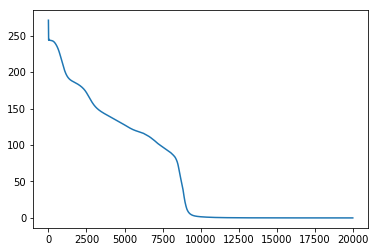

In [15]:
#Number of iterations vs. Loss for N = 1000

plt.plot(range(iter_count), losses)

In [16]:
#N = 10000

N = 10000
X = 4 * lhs(1, N) + 50 #Making the domain of X as [50, 54]
Y = 4 * lhs(1, N) + 50
Z = np.cos(np.pi * X) * np.cos(np.pi * Y)
Z = torch.from_numpy(Z)

Q = 50
d = 2
r = 1
w1 = np.ones((d, 1))
w2 = np.ones((Q, 1))
w3 = np.ones((Q, 1))

w1 = w1 * np.random.multivariate_normal([0], [[2/(d + Q)]], Q).T
w2 = w2 * np.random.multivariate_normal([0], [[2/(Q + Q)]], Q).T
w3 = w3 * np.random.multivariate_normal([0], [[2/(Q + r)]], r).T

b1 = np.zeros((1,Q))
b2 = np.zeros((1,Q))
b3 = np.zeros((1,r))

w1 = torch.from_numpy(w1)
w2 = torch.from_numpy(w2)
w3 = torch.from_numpy(w3)
b1 = torch.from_numpy(b1)
b2 = torch.from_numpy(b2)
b3 = torch.from_numpy(b3)

w1 = Variable(w1, requires_grad = True)
w2 = Variable(w2, requires_grad = True)
w3 = Variable(w3, requires_grad = True)
b1 = Variable(b1, requires_grad = True)
b2 = Variable(b2, requires_grad = True)
b3 = Variable(b3, requires_grad = True)

#Xavier Initialization
mean_X = np.mean(X)
std_X = np.std(X)
mean_Y = np.mean(Y)
std_Y = np.std(Y)

#X = (X - mean_X) / std_X
#Y = (Y - mean_Y) / std_Y

phi = np.concatenate(((X - mean_X) / std_X, (Y - mean_Y) / std_Y), axis=1)
phi = torch.from_numpy(phi)

In [17]:
loss_fn = torch.nn.MSELoss(reduction='sum')

var_list = [w1, w2, w3, b1, b2, b3]
optimizer = torch.optim.Adam(var_list, lr = .0001)

iter_count = 20000
losses = []

for i in range(iter_count):
    Z_pred = torch.matmul(torch.tanh(torch.matmul(torch.tanh(torch.matmul(phi, w1) + b1), w2) + b2), w3) + b3
    loss = loss_fn(Z_pred, Z)
    optimizer.zero_grad()
    loss.backward()
    print(loss.item())
    losses.append(loss.item())
    optimizer.step()

2583.0769803068065
2566.405314174308
2551.3778578377483
2538.025691363696
2526.3603366202947
2516.373270417369
2508.0360327369117
2501.2984333730906
2496.084295468557
2492.287680585259
2489.771564829637
2488.3696592441993
2487.891167904824
2488.128304403671
2488.866564026424
2489.8970708617553
2491.0294640899565
2492.103314691968
2492.9961595171276
2493.627031131922
2493.9555219483627
2493.9773161094877
2493.717467363797
2493.2225992608883
2492.552916403978
2491.7746716757943
2490.9535719558903
2490.149448718653
2489.412340438414
2488.7799634743005
2488.2764497137123
2487.912228873766
2487.684964916967
2487.5814324581656
2487.5801269221965
2487.6543029138143
2487.7751004656648
2487.914459726145
2488.0475938692953
2488.1548486717084
2488.22282971879
2488.2447506297735
2488.22005472741
2488.1534573328504
2488.053606671487
2487.931560224067
2487.7992465161997
2487.66805755265
2487.5476965410894
2487.445373645863
2487.36539226758
2487.309112354376
2487.275235302536
2487.260334427171
2487.2

2484.49526540612
2484.489328539947
2484.483360023728
2484.4773594148432
2484.4713262660584
2484.465260125339
2484.459160535914
2484.4530270360883
2484.446859159163
2484.4406564334613
2484.4344183821
2484.4281445230486
2484.421834368911
2484.415487426964
2484.409103198969
2484.4026811811527
2484.396220864091
2484.3897217325652
2484.383183265596
2484.376604936232
2484.3699862114886
2484.3633265522826
2484.356625413266
2484.349882242782
2484.343096482731
2484.336267568498
2484.3293949287713
2484.3224779855705
2484.3155161539407
2484.308508842047
2484.3014554508677
2484.294355374241
2484.2872079986596
2484.2800127031105
2484.272768859074
2484.265475830264
2484.2581329726463
2484.2507396341134
2484.2432951545643
2484.235798865608
2484.2282500905258
2484.220648144042
2484.212992332282
2484.2052819525557
2484.197516293211
2484.1896946335487
2484.18181624358
2484.1738803839153
2484.1658863056277
2484.157833250055
2484.1497204486514
2484.1415471228015
2484.133312483657
2484.125015732029
2484.11

2393.2184612225988
2392.224364092075
2391.224669840862
2390.219431285528
2389.2087021711404
2388.1925371508546
2387.1709917650287
2386.144122419793
2385.1119863650088
2384.0746416717993
2383.032147209463
2381.9845626218516
2380.931948303265
2379.8743653737674
2378.81187565411
2377.744541639994
2376.6724264760414
2375.5955939291352
2374.514108361453
2373.428034703038
2372.337438424008
2371.242385506375
2370.1429424155513
2369.0391760716316
2367.931153820316
2366.8189434037317
2365.702612930952
2364.5822308485303
2363.4578659108247
2362.3295871502864
2361.197463847736
2360.0615655027764
2358.921961804041
2357.7787225997963
2356.631917868511
2355.4816176897475
2354.327892215227
2353.170811640174
2352.010446174942
2350.846866017081
2349.680141323716
2348.5103421843805
2347.337538594414
2346.1618004286497
2344.9831974159683
2343.80179911412
2342.61767488535
2341.430893872696
2340.2415249767987
2339.049636833596
2337.8552977927347
2336.65857589657
2335.4595388601556
2334.258254051961
2333.05

1978.1653015654788
1977.7037398996454
1977.2438971962424
1976.7857660037887
1976.3293388719026
1975.8746083514666
1975.4215669948494
1974.9702073560209
1974.5205219907812
1974.0725034568877
1973.6261443142716
1973.1814371251626
1972.7383744542685
1972.2969488689382
1971.8571529393457
1971.4189792385914
1970.9824203429707
1970.5474688319978
1970.1141172886505
1969.682358299508
1969.2521844548598
1968.8235883489135
1968.3965625799028
1967.9710997502764
1967.5471924667727
1967.124833340641
1966.7040149877234
1966.2847300286217
1965.8669710888475
1965.4507307989124
1965.036001794525
1964.6227767166697
1964.2110482117655
1963.800808931795
1963.3920515344307
1962.9847686831479
1962.578953047375
1962.1745973025959
1961.771694130478
1961.3702362190188
1960.9702162626102
1960.5716269622078
1960.1744610254182
1959.77871116666
1959.384370107188
1958.991430575293
1958.5998853063509
1958.2097270430102
1957.82094853521
1957.433542540342
1957.0475018233444
1956.6628191568254
1956.2794873210785
1955.8

1852.8917525066154
1852.637598271544
1852.3832507828342
1852.1287095677167
1851.8739741598545
1851.6190440990358
1851.3639189309306
1851.1085982067605
1850.8530814829683
1850.5973683210004
1850.341458286951
1850.0853509512594
1849.8290458884323
1849.5725426767133
1849.315840897815
1849.0589401365567
1848.8018399805856
1848.5445400200854
1848.2870398474427
1848.0293390569507
1847.771437244472
1847.5133340071868
1847.2550289432177
1846.9965216513542
1846.7378117307599
1846.4788987806292
1846.2197823999093
1845.960462186994
1845.7009377393833
1845.4412086534196
1845.1812745239956
1844.9211349441887
1844.6607895050486
1844.400237795233
1844.1394794007585
1843.8785139046709
1843.6173408868099
1843.3559599234402
1843.0943705870584
1842.8325724460626
1842.5705650644445
1842.3083480015853
1842.0459208119164
1841.7832830447217
1841.5204342437667
1841.2573739471447
1840.9941016869573
1840.7306169890715
1840.466919372829
1840.2030083508898
1839.9388834288839
1839.6745441052572
1839.4099898709474


1710.6168476050066
1710.216030082311
1709.8152169669852
1709.4144134206813
1709.013624596486
1708.6128556383746
1708.2121116806507
1707.8113978474532
1707.4107192522413
1707.0100809972646
1706.6094881730783
1706.2089458580485
1705.80845911787
1705.4080330050565
1705.007672558546
1704.607382803175
1704.2071687492169
1703.8070353920293
1703.4069877114775
1703.007030671666
1702.607169220348
1702.2074082886515
1701.8077527906335
1701.408207622835
1701.0087776639587
1700.6094677744425
1700.2102827961266
1699.8112275518495
1699.412306845131
1699.013525459781
1698.614888159622
1698.2163996880947
1697.818064767934
1697.4198881009402
1697.021874367552
1696.6240282266215
1696.2263543151073
1695.828857247764
1695.4315416169156
1695.034411992099
1694.637472919908
1694.2407289236558
1693.8441845031903
1693.4478441345454
1693.051712269853
1692.655793337025
1692.260091739523
1691.8646118561853
1691.4693580410546
1691.0743346230806
1690.6795459059977
1690.2849961681509
1689.890689662258
1689.496630615

1573.5252617818567
1573.3187465970445
1573.1125762418555
1572.9067493070486
1572.7012643875228
1572.4961200824978
1572.2913149954952
1572.0868477343488
1571.882716911344
1571.6789211431471
1571.4754590508942
1571.272329260248
1571.0695304013868
1570.8670611090413
1570.6649200225677
1570.4631057859435
1570.2616170477697
1570.0604524613275
1569.8596106846476
1569.6590903804013
1569.458890216106
1569.2590088639363
1569.0594450009366
1568.8601973088869
1568.6612644744064
1568.462645188943
1568.2643381487555
1568.0663420550109
1567.8686556136577
1567.6712775355525
1567.4742065364358
1567.2774413368766
1567.080980662364
1566.8848232432754
1566.6889678148393
1566.4934131171826
1566.298157895346
1566.1032008991926
1565.908540883512
1565.7141766079244
1565.5201068369554
1565.3263303399806
1565.1328458912067
1564.9396522696998
1564.7467482593618
1564.5541326488901
1564.3618042318208
1564.1697618064588
1563.978004175918
1563.7865301480597
1563.595338535488
1563.4044281555646
1563.2137978303372
15

1501.475639370771
1501.3309915463703
1501.1863462897677
1501.0417032294931
1500.8970619951892
1500.7524222175653
1500.6077835284154
1500.4631455605233
1500.3185079477516
1500.1738703249573
1500.0292323279846
1499.8845935936479
1499.7399537597469
1499.5953124649754
1499.4506693490105
1499.306024052395
1499.1613762165698
1499.0167254838534
1498.8720714974247
1498.727413901263
1498.582752340223
1498.4380864599448
1498.2934159068081
1498.148740328027
1498.004059371521
1497.8593726859667
1497.7146799207255
1497.5699807258818
1497.425274752197
1497.2805616510855
1497.1358410746209
1496.991112675483
1496.8463761069715
1496.7016310229917
1496.5568770780126
1496.4121139270362
1496.2673412256495
1496.1225586299313
1495.9777657964798
1495.8329623823854
1495.6881480451893
1495.543322442896
1495.398485233959
1495.2536360772651
1495.1087746320427
1494.9639005579868
1494.8190135150958
1494.6741131637698
1494.5291991647082
1494.3842711789814
1494.2393288679054
1494.0943718931157
1493.9493999165445
149

1434.9592530106845
1434.806344729468
1434.6535297319494
1434.5008085511568
1434.3481817095287
1434.195649718972
1434.043213080856
1433.8908722860838
1433.7386278151262
1433.5864801380671
1433.4344297146292
1433.2824769942395
1433.130622416098
1432.9788664091623
1432.8272093923026
1432.6756517742433
1432.5241939537514
1432.3728363195542
1432.221579250499
1432.0704231156155
1431.9193682741181
1431.7684150755192
1431.6175638597138
1431.4668149569857
1431.3161686881417
1431.1656253645485
1431.0151852882195
1430.8648487519026
1430.7146160391105
1430.5644874242673
1430.414463172717
1430.264543540855
1430.114728776193
1429.9650191174053
1429.8154147944747
1429.665916028743
1429.516523032966
1429.367236011445
1429.2180551601186
1429.068980666566
1428.9200127102129
1428.7711514623143
1428.6223970861051
1428.4737497368642
1428.3252095619875
1428.1767767011413
1428.028451286241
1427.880233441652
1427.7321232842257
1427.5841209233788
1427.4362264611966
1427.28843999256
1427.1407616051545
1426.9931

1376.9484133043873
1376.8397282190763
1376.7311711521686
1376.622742259319
1376.5144416931162
1376.4062696030435
1376.2982261355048
1376.1903114337788
1376.0825256380278
1375.9748688852683
1375.8673413094075
1375.7599430411824
1375.652674208163
1375.5455349347712
1375.4385253422415
1375.3316455486502
1375.2248956688463
1375.1182758145223
1375.0117860941477
1374.905426613018
1374.7991974731822
1374.6930987735154
1374.587130609646
1374.481293074008
1374.3755862557912
1374.2700102409729
1374.1645651123122
1374.0592509493338
1373.954067828323
1373.8490158223701
1373.7440950012808
1373.6393054316945
1373.5346471769974
1373.4301202973325
1373.3257248496352
1373.2214608876225
1373.1173284617832
1373.0133276193817
1372.909458404474
1372.8057208579219
1372.702115017337
1372.598640917157
1372.4952985886162
1372.3920880597539
1372.2890093554174
1372.1860624972494
1372.0832475037587
1371.9805643902266
1371.8780131688118
1371.7755938484722
1371.673306435065
1371.5711509312323
1371.46912733654
1371.

1339.6243517974187
1339.5462625041205
1339.4680004737086
1339.3895611793228
1339.3109399968469
1339.2321322024848
1339.1531329701234
1339.0739373687486
1338.9945403597171
1338.9149367940176
1338.8351214094005
1338.7550888274636
1338.6748335506588
1338.5943499592117
1338.5136323079655
1338.4326747231762
1338.3514711991622
1338.2700155948853
1338.1883016305164
1338.1063228838004
1338.0240727864418
1337.941544620309
1337.8587315135721
1337.7756264368395
1337.692222198982
1337.608511443108
1337.5244866422938
1337.440140095227
1337.3554639217696
1337.270450058433
1337.1850902537167
1337.0993760633694
1337.013298845509
1336.9268497557011
1336.8400197418378
1336.7527995389337
1336.6651796639464
1336.5771504102324
1336.4887018421277
1336.3998237893077
1336.3105058409897
1336.2207373401473
1336.1305073775632
1336.0398047856816
1335.9486181324883
1335.8569357151725
1335.7647455537726
1335.6720353846144
1335.5787926537137
1335.485004510046
1335.390657798682
1335.2957390539086
1335.200234492107
13

1249.257431388184
1249.0999174421445
1248.9428555517086
1248.786240976233
1248.630069124769
1248.4743355514456
1248.3190359509492
1248.1641661540211
1248.0097221230621
1247.8556999477842
1247.7020958408727
1247.548906133872
1247.396127273071
1247.2437558154058
1247.0917884246867
1246.9402218676432
1246.7890530102861
1246.638278814304
1246.4878963335034
1246.337902710434
1246.188295173096
1246.0390710317208
1245.8902276757235
1245.7417625706444
1245.5936732553453
1245.4459573391794
1245.2986124992824
1245.1516364780325
1245.0050270805373
1244.8587821722365
1244.7128996765491
1244.5673775727491
1244.4222138937114
1244.2774067239584
1244.1329541976315
1243.9888544966334
1243.8451058487626
1243.7017065260466
1243.5586548430479
1243.4159491551957
1243.273587857337
1243.1315693822346
1242.9898921991614
1242.8485548125495
1242.7075557606947
1242.5668936145264
1242.4265669764304
1242.2865744791059
1242.14691478444
1242.0075865825893
1241.8685885908515
1241.7299195527994
1241.5915782373206
1241

1206.7647102807625
1206.7125417220418
1206.6605095520447
1206.6086134747209
1206.5568531943845
1206.505228415846
1206.4537388443161
1206.4023841853802
1206.3511641450032
1206.3000784295023
1206.2491267455039
1206.1983087999943
1206.1476243001975
1206.0970729536314
1206.0466544680714
1205.9963685515513
1205.9462149122676
1205.8961932586983
1205.8463032994557
1205.796544743371
1205.7469172993872
1205.6974206766315
1205.648054584349
1205.5988187319085
1205.549712828788
1205.5007365845606
1205.4518897088751
1205.4031719114357
1205.3545829020575
1205.306122390549
1205.2577900867775
1205.2095857006675
1205.161508942137
1205.1135595210937
1205.0657371475054
1205.0180415312784
1204.9704723823468
1204.923029410589
1204.8757123258865
1204.8285208380569
1204.7814546569177
1204.7345134921798
1204.687697053559
1204.6410050506795
1204.5944371931034
1204.5479931903412
1204.5016727518052
1204.4554755868498
1204.409401404762
1204.3634499146851
1204.3176208257348
1204.2719138469035
1204.2263286870948
12

1193.0116433214616
1192.993087806097
1192.9745635013742
1192.9560702806943
1192.9376080172797
1192.9191765841351
1192.9007758540586
1192.8824056996277
1192.8640659931518
1192.845756606712
1192.827477412105
1192.8092282808675
1192.7910090842356
1192.7728196931441
1192.7546599782258
1192.736529809797
1192.7184290578368
1192.7003575919762
1192.6823152815064
1192.6643019953653
1192.6463176021084
1192.62836196993
1192.6104349666189
1192.5925364595969
1192.5746663158632
1192.5568244020108
1192.5390105842305
1192.5212247282775
1192.503466699495
1192.4857363627716
1192.4680335825578
1192.4503582228617
1192.4327101472475
1192.4150892188154
1192.3974953001875
1192.3799282535324
1192.3623879405618
1192.3448742224814
1192.3273869600428
1192.3099260134982
1192.292491242621
1192.2750825067026
1192.2576996645262
1192.2403425743962
1192.2230110941034
1192.2057050809574
1192.1884243917573
1192.1711688828075
1192.1539384098912
1192.1367328283177
1192.1195519928565
1192.102395757794
1192.0852639768952
11

1185.3452000063817
1185.321520915668
1185.2977793489372
1185.2739752976508
1185.2501087579797
1185.226179730708
1185.2021882211725
1185.1781342390684
1185.1540177984068
1185.1298389173578
1185.1055976181092
1185.0812939267678
1185.0569278731787
1185.0324994908133
1185.0080088166
1184.983455890747
1184.958840756647
1184.9341634606428
1184.9094240518752
1184.884622582155
1184.8597591057223
1184.8348336791128
1184.8098463609406
1184.7847972117315
1184.7596862937553
1184.7345136707725
1184.7092794079153
1184.6839835714334
1184.6586262285434
1184.6332074471989
1184.6077272959376
1184.5821858436327
1184.5565831593415
1184.5309193120854
1184.5051943706712
1184.4794084034954
1184.4535614783424
1184.427653662213
1184.401685021135
1184.3756556199771
1184.3495655222703
1184.3234147900243
1184.2972034835773
1184.270931661403
1184.2445993799874
1184.2182066935934
1184.191753654184
1184.1652403112516
1184.1386667116528
1184.112032899483
1184.085338915951
1184.05858479925
1184.031770584427
1184.00489

1168.294848812359
1168.2371184045817
1168.1792678175736
1168.1212968601787
1168.063205350874
1168.0049931179533
1167.9466599997006
1167.888205844605
1167.8296305115218
1167.7709338698633
1167.7121157997892
1167.6531761924011
1167.5941149498888
1167.5349319857532
1167.475627224932
1167.4162006040308
1167.3566520714612
1167.2969815876304
1167.2371891251078
1167.1772746687966
1167.1172382160835
1167.057079777048
1166.996799374585
1166.936397044593
1166.8758728361065
1166.8152268114684
1166.7544590465207
1166.6935696306907
1166.6325586671878
1166.5714262731537
1166.510172579795
1166.4487977324877
1166.3873018910192
1166.3256852296327
1166.2639479372042
1166.2020902173601
1166.1401122886257
1166.078014384548
1166.0157967537689
1165.953459660248
1165.8910033832635
1165.8284282176164
1165.7657344736892
1165.702922477565
1165.6399925711323
1165.5769451121778
1165.5137804744725
1165.450499047885
1165.3871012384504
1165.3235874684258
1165.2599581764212
1165.1962138174076
1165.132354862843
1165.0

1141.3322559260798
1141.2854259223675
1141.2386410140366
1141.191900781005
1141.1452048038386
1141.0985526637146
1141.05194394237
1141.0053782221319
1140.9588550858084
1140.9123741167302
1140.865934898701
1140.8195370159854
1140.7731800532517
1140.7268635955568
1140.6805872283644
1140.634350537461
1140.5881531089797
1140.5419945293402
1140.4958743852799
1140.4497922637622
1140.4037477520121
1140.3577404374807
1140.3117699078243
1140.2658357508842
1140.2199375546681
1140.1740749073786
1140.1282473972826
1140.0824546128738
1140.0366961426662
1139.9909715753547
1139.9452804996718
1139.8996225044768
1139.853997178666
1139.8084041112243
1139.7628428912042
1139.7173131076913
1139.6718143498333
1139.626346206832
1139.5809082679318
1139.5355001224175
1139.490121359623
1139.4447715689266
1139.399450339762
1139.3541572616155
1139.3088919240288
1139.263653916607
1139.2184428290177
1139.173258251041
1139.1280997725075
1139.0829669833715
1139.037859473692
1138.9927768336368
1138.9477186535344
1138.

1121.0725258682205
1121.02086280017
1120.9691339079593
1120.917338701324
1120.865476713204
1120.8135475013953
1120.761550650456
1120.7094857733941
1120.657352513763
1120.605150547318
1120.5528795842708
1120.5005393708843
1120.4481296918968
1120.3956503720697
1120.3431012787023
1120.2904823230854
1120.2377934632602
1120.1850347050683
1120.1322061053181
1120.0793077724602
1120.0263398699628
1119.9733026165422
1119.9201962900609
1119.867021226759
1119.8137778261553
1119.7604665487668
1119.7070879224752
1119.6536425380336
1119.6001310577678
1119.546554207611
1119.4929127896298
1119.4392076686447
1119.3854397909824
1119.3316101624207
1119.2777198772815
1119.223770082405
1119.1697620233324
1119.115696985453
1119.0615763688452
1119.0074015916205
1118.953174213125
1118.8988957742422
1118.8445680028703
1118.7901925481988
1118.7357713280403
1118.6813060841841
1118.6267989779367
1118.572251844705
1118.5176672344523
1118.4630471699384
1118.408395015198
1118.3537134592445
1118.2990080225518
1118.24

1097.7383420480014
1097.6770363764963
1097.6168279259616
1097.5571746504165
1097.4973035530688
1097.4366779860572
1097.375181224991
1097.3132217778048
1097.2513370236381
1097.1898907220668
1097.128849508352
1097.0678756282277
1097.0065944495202
1096.9447991652567
1096.8825940750182
1096.8202491729794
1096.7580250270137
1096.6959821714502
1096.6339772606573
1096.5717975983064
1096.5092996165217
1096.4465082827905
1096.3835501661645
1096.320567079709
1096.2576073197777
1096.1946200637067
1096.131509889291
1096.068200227006
1096.0046847804037
1095.9410020431644
1095.8772138573179
1095.8133537081083
1095.7494214038295
1095.6853888316984
1095.6212200596626
1095.5568969089813
1095.4924163271453
1095.4277978517748
1095.3630602413325
1095.2982193758014
1095.2332759520043
1095.1682195160054
1095.1030370212904
1095.0377160739467
1094.9722569343269
1094.9066635754223
1094.8409475444287
1094.7751153011295
1094.709169880683
1094.6431084187052
1094.5769247175544
1094.51061513433
1094.444176396717
10

1062.6468974968354
1062.5478314383122
1062.448658380592
1062.3493783379251
1062.249991290402
1062.150497226795
1062.05089615143
1061.9511880388839
1061.851372910048
1061.7514507333178
1061.6514215337581
1061.5512852804698
1061.4510419923922
1061.3506916455935
1061.250234250002
1061.149669792721
1061.0489982747413
1060.9482196942688
1060.8473340452795
1060.7463413333317
1060.6452415472334
1060.5440346963667
1060.4427207675303
1060.341299771129
1060.2397716948287
1060.138136548759
1060.0363943232805
1059.9345450268638
1059.8325886532937
1059.7305252088022
1059.628354690407
1059.5260771017176
1059.4236924428888
1059.321200715297
1059.218601921899
1059.1158960623409
1059.0130831421127
1058.910163159634
1058.8071361222223
1058.7040020276133
1058.6007608844423
1058.497412690199
1058.3939574540245
1058.290395173762
1058.1867258585496
1058.082949507012
1057.9790661278562
1057.875075720864
1057.7709782939808
1057.6667738483075
1057.562462390848
1057.4580439241022
1057.3535184540665
1057.2488859

1007.4138286855542
1007.2430323072631
1007.0714874725236
1006.8993339282199
1006.7267833425299
1006.5539084626819
1006.3805812729653
1006.2066437923528
1006.0320962202209
1005.8570275735038
1005.6815188701123
1005.5055355601021
1005.3290023428616
1005.1518983063527
1004.9742630752881
1004.7961490762751
1004.6175453822746
1004.4384041401371
1004.2586921666054
1004.0784241227117
1003.89763950219
1003.7163558091174
1003.5345537646564
1003.3522047883573
1003.169297466437
1002.9858454106028
1002.801865531258
1002.617356450307
1002.4323078691472
1002.2467061134545
1002.0605547876703
1001.8738607284168
1001.6866271327449
1001.49884947643
1001.3105157319793
1001.1216243634532
1000.9321753294325
1000.7421747762651
1000.5516216489141
1000.3605101650928
1000.1688351869286
999.9765916422092
999.7837813893914
999.590402990475
999.3964552384391
999.201933310356
999.0068326102113
998.8111508743999
998.6148855804067
998.4180351450024
998.2205952527011
998.0225614997438
997.8239292853928
997.6246950283

888.4493753577782
888.1731479251084
887.8969281699598
887.6207149326541
887.344507056744
887.068303391212
886.7921027894761
886.5159041119261
886.2397062246771
885.9635080024061
885.6873083267594
885.4111060896508
885.1349001911819
884.8586895434889
884.5824730681603
884.3062497006691
884.0300183871262
883.7537780895998
883.4775277819144
883.2012664561561
882.9249931171479
882.6487067906202
882.3724065158358
882.0960913560724
881.8197603886641
881.5434127186436
881.2670474652142
880.9906637798781
880.7142608276953
880.4378378118738
880.1613939474965
879.8849284954796
879.6084407252594
879.3319299623683
879.0553955349799
878.7788368414614
878.5022532729033
878.2256443105109
877.9490094119507
877.6723481537438
877.3956600626054
877.1189448264788
876.8422020414166
876.5654315283251
876.28863294901
876.0118062874427
875.7349512611569
875.4580680612607
875.1811564409512
874.9042168667035
874.6272490930519
874.3502539742124
874.0732312158472
873.7961822594579
873.5191067084509
873.2420069776

779.188894643355
778.9131166492065
778.6356760106153
778.3565524865535
778.0757263140838
777.793178425152
777.5088904357722
777.2228447524581
776.9350246840065
776.6454144608181
776.3539994105412
776.0607659635559
775.7657018144116
775.4687959696926
775.1700388584155
774.8694224228275
774.5669401967843
774.2625873908992
773.956360985736
773.6482597608672
773.3382844254965
773.0264375803335
772.7127238633274
772.3971498732952
772.079724281717
771.7604577549747
771.4393629973897
771.116454680101
770.7917494187201
770.465265683214
770.1370237405989
769.807045511258
769.4753545036043
769.1419756037169
768.8069350046047
768.4702599446047
768.1319786172329
767.7921198839115
767.4507131572559
767.1077881009085
766.7633745017673
766.4175019503149
766.0701997346357
765.7214964874938
765.3714201351381
765.0199975040836
764.6672543479629
764.3132149137533
763.9579020667638
763.6013368083414
763.2435385312699
762.8845244576811
762.5243100808349
762.1629084601105
761.800330933836
761.4365861716187


362.73064852696507
361.34506070153355
359.9547202396394
358.55975276547866
357.1602997259102
355.756517869955
354.3485786311353
352.9366674152757
351.5209827989123
350.10173564558136
348.6791481492623
347.25345281592877
345.8248913954822
344.39371377721875
342.96017686247745
341.5245434282719
340.0870809953847
338.6480607137837
337.2077562773477
335.7664428785971
334.3243962128492
332.8818915395619
331.4392028070937
329.99660184538305
328.5543576295716
327.11273561599864
325.6719971508201
324.23239895028416
322.79419265080395
321.3576244262742
319.92293466932784
318.4903577329604
317.06012172831043
315.63244837414726
314.2075528931726
312.7856439500068
311.3669236253374
309.9515874206657
308.53982428794546
307.1318166785593
305.7277406063598
304.327765719985
302.93205538025484
301.54076673923737
300.1540508183279
298.7720525835133
297.394911016808
296.0227591833995
294.6557242947615
293.29392776824864
291.93748528412436
290.5865068410294
289.24109681096934
287.9013539949399
286.5673716

60.30700251510213
60.11267005904524
59.91935975694505
59.72706596659661
59.535783003504115
59.345505146873926
59.15622664526204
58.9679417218588
58.78064457940631
58.594329404726835
58.408990372875735
58.22462165091517
58.04121740132542
57.858771785056504
57.677278964253844
57.496733104667555
57.31712837777321
57.13845896263129
56.96071904751701
56.78390283133514
56.60800452486624
56.43301835186157
56.25893855001472
56.085759371838634
55.91347508547413
55.74207997544625
55.57156834339149
55.40193450877743
55.23317280962207
55.065277603234435
54.898243266974546
54.73206419905614
54.56673481938272
54.40224957042932
54.23860291816855
54.07578935303957
53.91380339095965
53.752639574375294
53.592292473346426
53.432756686662515
53.274026842980525
53.11609760198343
52.958963655548935
52.802619728924604
52.647060581901805
52.49228100998471
52.33827584554507
52.18503995895881
52.032568259720776
51.88085569753203
51.72989726335165
51.57968799041529
51.43022295521275
51.28149727842131
51.13350612

22.49887539740064
22.462509136266032
22.42626545437743
22.390143968984173
22.354144295982874
22.318266049485544
22.282508843393945
22.246872289524898
22.211355999385404
22.175959583190654
22.14068264994042
22.10552480841465
22.070485665675267
22.0355648286848
22.00076190325877
21.96607649433133
21.931508206632582
21.89705664353011
21.862721408340732
21.828502103435206
21.79439833056219
21.760409691225274
21.726535785943366
21.692776215169605
21.659130578593633
21.625598475543125
21.592179505035514
21.5588732654529
21.52567935511768
21.492597371741248
21.45962691290618
21.42676757586777
21.39401895752787
21.361380654768165
21.328852264017513
21.29643338174898
21.264123604165356
21.231922527337662
21.19982974736852
21.16784486009783
21.135967461516504
21.104197147463726
21.072533513832067
21.040976156595057
21.009524671680392
20.978178655233204
20.946937703396543
20.91580141252719
20.884769379121963
20.853841199842822
20.82301647162852
20.792294791575078
20.761675757127833
20.73115896595

13.740347819260661
13.72932231926339
13.718314601134535
13.70732459526319
13.696352236440418
13.685397457438876
13.674460188786096
13.663540362514485
13.652637912092539
13.641752772560196
13.630884877081312
13.620034158263739
13.609200550894194
13.598383989939753
13.587584410908006
13.576801748496342
13.566035937400668
13.555286914232378
13.544554615200113
13.533838976760045
13.523139935406846
13.51245742762558
13.501791391410912
13.491141764318671
13.480508483993662
13.469891488628972
13.45929071633888
13.448706106315608
13.438137597517272
13.42758512891698
13.41704864023309
13.40652807109483
13.396023361844758
13.385534452841485
13.375061284453867
13.364603797762438
13.354161933816933
13.343735634146567
13.333324840462804
13.322929494520247
13.312549538659972
13.302184915277662
13.291835567126004
13.281501437201104
13.271182468595118
13.260878604867766
13.250589789695868
13.24031596706219
13.23005708119079
13.219813076453905
13.209583897608203
13.19936948955342
13.189169797482357
13.

10.007673966650437
10.000891747408133
9.994113638588296
9.987339444742357
9.980569289797204
9.973803355417832
9.967041564708474
9.960283746978595
9.953529916984573
9.946780195526602
9.940034597412495
9.93329301607814
9.926555401257696
9.919821819927574
9.913092312820291
9.906366832606446
9.89964532337019
9.892927794246459
9.886214287829702
9.879504794673698
9.872799271253534
9.866097703733258
9.859400109441568
9.852706499969273
9.8460168529927
9.839331143934727
9.83264937554034
9.825971555854943
9.819297680046018
9.81262772973523
9.805961693482836
9.799299575556583
9.79264137518634
9.78598708281094
9.779336686580157
9.772690180576898
9.76604756600611
9.759408837723813
9.752773986474642
9.74614300474197
9.73951588797197
9.732892634476574
9.726273237848376
9.719657690265265
9.713045986285252
9.706438121287384
9.699834091870741
9.693233891731847
9.686637514254818
9.680044954764194
9.67345620837061
9.666871270896163
9.66029013649751
9.653712799334007
9.647139254956285
9.640569498350018
9.6

7.2900337740551535
7.28504464692837
7.280058006403966
7.275073765647662
7.270092086342818
7.265113006860391
7.260136372043312
7.255162159233077
7.250190506968491
7.245221420137485
7.240254777486663
7.235290572334375
7.230328889352405
7.225369728636503
7.220413023458203
7.21545877075315
7.210507018606208
7.205557754664269
7.200610933076042
7.195666566178856
7.190724684082208
7.185785271938076
7.180848298015708
7.1759137642778414
7.170981693436734
7.1660520772803045
7.161124892745117
7.156200142100344
7.151277833969937
7.1463579607994285
7.141440509364553
7.136525478935375
7.131612876174654
7.12670269416506
7.121794920102657
7.116889553149824
7.111986595787062
7.107086043349119
7.102187887625023
7.097292124217801
7.092398753629411
7.087507771622291
7.0826191704177885
7.077732947193906
7.072849100109854
7.067967625129348
7.063088516202067
7.058211768077011
7.053337378942225
7.04846534491847
7.043595660156206
7.038728320325166
7.033863321531847
7.029000659967819
7.024140330509561
7.0192823

5.1876283989443595
5.1833733067769305
5.179126885959887
5.174889158545628
5.170660142618322
5.166439851975741
5.16222829643342
5.158025481794814
5.153831409905965
5.149646078872956
5.1454694829293475
5.141301612821045
5.137142455564462
5.132991994927474
5.128850211130124
5.124717081388468
5.120592579565867
5.116476676787324
5.112369341015319
5.108270537768894
5.104180229579475
5.100098376858194
5.096024937186872
5.091959866374443
5.087903117535748
5.08385464239038
5.079814390059043
5.075782308692848
5.071758343870014
5.067742440704526
5.063734541652091
5.059734589337537
5.0557425234714755
5.05175828476841
5.047781810518212
5.043813040170761
5.0398519088607685
5.035898355569511
5.031952313509339
5.028013722344045
5.024082513712439
5.020158629999375
5.0162420023173375
5.012332580196792
5.008430298019637
5.0045351237633975
5.000647008640331
4.996765971423028
4.992892027441845
4.98902534622771
4.985166170977928
4.9813151477890445
4.977473318308469
4.973642909441754
4.969827775556918
4.9660

3.7496196924952825
3.747036147183185
3.7444542008557153
3.741873851311032
3.739295097275422
3.7367179366796077
3.7341423679688184
3.7315683889579003
3.7289959977462765
3.726425192210985
3.7238559703612086
3.7212883302844175
3.718722269975494
3.7161577876280707
3.7135948811496173
3.7110335487245325
3.708473788186481
3.705915597734033
3.703358975215969
3.7008039188883295
3.698250426641459
3.6956984967608086
3.6931481271379196
3.6905993160395605
3.688052061336896
3.6855063612722074
3.682962213717542
3.6804196169104886
3.6778785687472695
3.6753390674668296
3.6728011109886416
3.6702646975429003
3.667729825059005
3.665196491753399
3.6626646955580826
3.6601344346858022
3.65760570706916
3.655078510933271
3.6525528442061614
3.6500287051395426
3.6475060916454733
3.6449850020152716
3.6424654341316636
3.6399473863444536
3.6374308564962488
3.634915843026983
3.6324023437340185
3.6298903572012824
3.6273798811862754
3.6248709145133473
3.6223634549354657
3.619857501703818
3.6173530526859388
3.614850107

2.7720681302368133
2.771687748124862
2.7719008903208096
2.772713773095958
2.7738293060375523
2.774496538760258
2.773504798575132
2.7698536967962837
2.7636776413109962
2.7566875854195945
2.7511361525869935
2.7483086709136515
2.7478758428120806
2.7483766808783887
2.7481438931100253
2.7461460119332326
2.742502282051239
2.7383489877303218
2.735042259612435
2.733220278497592
2.7324652894114907
2.7317399893485734
2.730167353839506
2.727592952256974
2.7245796327481346
2.721899169961039
2.7199528234542467
2.7185740269525525
2.7172690883538873
2.715613407872094
2.7135038599528016
2.711147773756335
2.7088661563605236
2.7068714298146883
2.705162627696637
2.7035693588981355
2.7018849747255933
2.6999964373388012
2.697937136860581
2.6958446618156806
2.6938573303558746
2.6920260663184727
2.6902965426899867
2.6885627357446027
2.686743683768838
2.684828335506739
2.682867693774097
2.6809293840768196
2.6790538395747143
2.6772376405584293
2.6754467446010435
2.6736426855521644
2.6718033845746882
2.66993040

2.0275834942136197
2.0262042636899062
2.0247161108889324
2.023221010406861
2.0218103727021584
2.0204694817219293
2.01911415108621
2.017693341900679
2.016236301298713
2.0148058337850445
2.01342630169339
2.012065940836128
2.0106806604785863
2.009261717044501
2.0078374558220595
2.006437250342196
2.005061590277089
2.0036873503540695
2.002295572163438
2.0008893136509305
1.9994862939534417
1.9980985290909687
1.9967217978013077
1.9953429626474648
1.993954342713314
1.9925600175863425
1.9911695257040691
1.9897877907119368
1.988411391454668
1.9870334192989256
1.9856506124875775
1.984265577158818
1.9828832593940182
1.9815059372962933
1.980131711508016
1.9787570531182006
1.9773802533030793
1.9760026021333812
1.9746266126064764
1.9732535990667381
1.9718827624824007
1.9705123030630192
1.9691411795089957
1.9677698153692313
1.9663994685198638
1.965030985628934
1.9636641919060749
1.9622982410717604
1.9609324354567885
1.9595667802494414
1.9582018172151974
1.9568380973638273
1.9554757280720119
1.95411438

1.5068437459617725
1.5058678565916448
1.504892666772627
1.5039181827831505
1.5029444102027167
1.5019713561835093
1.5009990239100859
1.5000274149534292
1.4990565277428356
1.49808635908858
1.4971169056836524
1.4961481636876692
1.4951801315670967
1.4942128076180403
1.4932461929127774
1.4922802877260943
1.4913150941257372
1.4903506127043873
1.4893868447041085
1.4884237899848283
1.487461448455276
1.4864998194071333
1.4855389019661251
1.4845786954713533
1.4836191989173426
1.4826604120276572
1.4817023339614588
1.480744964802796
1.479788303904725
1.4788323515428454
1.4778771072017722
1.476922571175123
1.4759687430023474
1.4750156228681848
1.4740632103155513
1.4731115053674473
1.47216050756951
1.4712102168015024
1.4702606326457008
1.4693117548855237
1.4683635831692172
1.46741611721878
1.4664693567523261
1.465523301444798
1.4645779510725105
1.4636333052696588
1.4626893638587861
1.4617461264404876
1.4608035928770964
1.4598617627423778
1.458920635935343
1.4579802120060041
1.457040490890297
1.45610

1.1596777943718597
1.1628253429883606
1.1634529381074499
1.1607683785409775
1.1563682843529444
1.1529131330435956
1.151995307764676
1.1531153419647366
1.1544254794585176
1.1542911419917619
1.1524317094256187
1.1499204734183233
1.1481602609255157
1.1477432060720187
1.1481484284669583
1.148349969033753
1.1476765571880445
1.1462484390637668
1.1447434392073963
1.143779648440066
1.14345561840322
1.1433784899343373
1.1430541202148425
1.1422711439299609
1.1412025015070515
1.1402031054411812
1.1395124677998274
1.1391013614431942
1.1387471151654938
1.1382327891641748
1.137500494569021
1.1366610404748456
1.1358814397962627
1.135255904044096
1.1347544620326464
1.1342690077593576
1.1337034069519814
1.133036202765716
1.1323200103305122
1.1316308939010211
1.131012934491149
1.130455566780744
1.129911731058908
1.1293358653183707
1.1287126660655502
1.128060633418007
1.1274132985800431
1.1267952189805215
1.126208557298285
1.125636404558736
1.125056994671234
1.1244577008235876
1.1238406722359702
1.123218

0.9274702837853595
0.9249984206163947
0.9255882794610412
0.9267766741137523
0.9261253781982358
0.9244066036227043
0.9237147992690842
0.9241235510756154
0.923934691560768
0.9224972224892141
0.9210817556274491
0.9208459396534944
0.9212503614925815
0.9210705783345073
0.9201281769643751
0.91926527534563
0.9189644706845808
0.9187816624110574
0.9181988894998588
0.9174076417511127
0.9169269455685024
0.9168020010550552
0.9165909998227298
0.9160316333897129
0.915354182743465
0.9148785506540879
0.9145775481698231
0.9142034044316955
0.9136831646386769
0.9131844835393145
0.9128297706963578
0.9125245767471474
0.9121164416156714
0.9116067625718267
0.9111214639153926
0.9107263235151184
0.9103600850111967
0.9099454909286993
0.9094941271980829
0.9090704481151034
0.9086928375511235
0.9083146566344851
0.907894670313953
0.90744898298272
0.9070210662593842
0.9066234592767981
0.9062298759811639
0.9058173693583711
0.9053949545330998
0.9049852039112634
0.9045917206575939
0.9041968670767154
0.9037871363664524


0.7691775560571186
0.7690471735848543
0.7689921636457486
0.7686882659706298
0.7681651543017166
0.7677027412481259
0.7674594586775713
0.7673143506891326
0.7670599892218991
0.7666548348324553
0.7662374812187149
0.7659348698075894
0.765722164469858
0.7654803657362304
0.7651469038500727
0.7647735747736847
0.7644468312255593
0.7641862334988819
0.76393632783705
0.7636415401002618
0.7633060869553498
0.7629775132765896
0.7626873251503327
0.7624206653757379
0.7621411869180241
0.7618334973436114
0.7615150238042786
0.7612113650131271
0.7609281545400033
0.7606492303560217
0.7603574959508735
0.7600524597866622
0.7597474244400642
0.759453325622396
0.7591682661993377
0.7588819555726196
0.7585875415279251
0.758287661186405
0.7579899438869189
0.7576986057444061
0.7574110507506056
0.7571217200224507
0.7568279903458955
0.7565320572981229
0.756237905975793
0.7559472082081271
0.7556582313260746
0.7553681232886323
0.7550757499287382
0.7547823904254846
0.7544900811315274
0.7541996315917451
0.7539101426861238

0.654595015322802
0.6543683300863122
0.6541418307275878
0.6539155811465511
0.6536895314297246
0.6534635680411451
0.6532375860550786
0.6530115439404464
0.6527854700504079
0.6525594354498486
0.6523335068336896
0.6521077150143366
0.6518820463836856
0.6516564591896461
0.6514309103263375
0.651205375173427
0.6509798562396842
0.650754374522095
0.6505289570812102
0.6503036225554049
0.6500783756173458
0.6498532077173905
0.6496281035161847
0.649403049098008
0.6491780366644325
0.648953067200624
0.6487281472938032
0.6485032861675375
0.6482784907625719
0.648053764060988
0.6478291044949188
0.6476045075976821
0.6473799684392681
0.647155483166528
0.6469310505647606
0.646706671293364
0.6464823477703115
0.6462580824155527
0.6460338773384059
0.6458097333944236
0.6455856504413823
0.645361627503933
0.6451376632018421
0.6449137563783206
0.6446899061257244
0.6444661122863279
0.6442423749711965
0.6440186948162941
0.6437950723454056
0.6435715081539283
0.6433480024915802
0.6431245554655167
0.6429011669369967
0.

0.5662834074901563
0.566167716182549
0.5659078807811496
0.5656254793001655
0.5654507190932546
0.5653496273141236
0.5652009240914517
0.5649705956087383
0.5647362487210056
0.564563813026773
0.564428116360295
0.5642658541829327
0.5640615140866273
0.5638536263414202
0.5636758063008379
0.5635193817350341
0.5633538540392916
0.5631662066053477
0.5629711937269759
0.5627891278501667
0.5626223566289944
0.5624557746503074
0.5622765784046375
0.5620885977181771
0.5619056108460042
0.5617338341338498
0.5615655112882997
0.561390054312987
0.5612071435912427
0.5610256028129355
0.560851432258152
0.5606811911170486
0.5605078419396573
0.5603298184130976
0.5601519372107903
0.5599788058038997
0.5598101019768555
0.5596427749639802
0.5594761365105331
0.5593136474714909
0.5591607490865064
0.5590226760797514
0.5589054466796401
0.5588194281475516
0.5587834946000162
0.5588290184398758
0.5590054170558602
0.559389342993384
0.5600994015832191
0.5613142478979577
0.5632868655173954
0.5663292345337275
0.5707145611920402

0.4975686676151839
0.4974245795593687
0.4972805089529126
0.49713645567654197
0.49699241976297054
0.49684840126589275
0.4967044003322637
0.49656041706623627
0.49641645159393166
0.49627250397140865
0.49612857424214785
0.49598466239909517
0.4958407684205163
0.4956968922732437
0.4955530339158644
0.4954091933272856
0.4952653704780971
0.4951215653738345
0.49497777800446313
0.49483400839603203
0.49469025655073545
0.49454652250209846
0.49440280625539856
0.4942591078416419
0.4941154272642357
0.4939717645476073
0.4938281196926986
0.4936844927176289
0.49354088362243326
0.49339729242082725
0.4932537191136296
0.49311016371197247
0.4929666262184104
0.4928231066426761
0.49267960498925417
0.4925361212670336
0.4923926554821722
0.49224920764296476
0.4921057777568447
0.49196236583160075
0.4918189718756171
0.4916755958962323
0.4915322379025443
0.49138889790149015
0.4912455759028006
0.49110227191304134
0.49095898594262605
0.49081571799778595
0.49067246808982035
0.49052923622468075
0.4903860224149956
0.4902

0.44364415675109153
0.4435320135480261
0.44341873506280227
0.4433035853480714
0.4431879229928616
0.4430738559317068
0.4429619760103351
0.4428507488429983
0.4427381369208904
0.44262360175782295
0.4425084453132241
0.4423943582456316
0.44228183275080046
0.44216994572030255
0.44205745266695173
0.4419439273686519
0.44182991360871554
0.4417162058998149
0.44160311791519674
0.44149038213059066
0.44137757219353185
0.4412645109780805
0.441151312184531
0.44103814674313224
0.44092505468217474
0.4408119673508748
0.44069884722632924
0.44058575287224117
0.44047276605467595
0.44035988407415505
0.4402470043358838
0.44013401836580973
0.4400209130249885
0.4399077811177816
0.4397947370411897
0.4396818224202419
0.4395689830550325
0.439456125197738
0.43934319247827813
0.4392301985741486
0.439117200777583
0.43900424772667085
0.4388913480242039
0.4387784768816544
0.43866560532455867
0.43855272239002785
0.4384398355690464
0.4383269564957411
0.4382140883878164
0.4381012261492125
0.43798836462712015
0.4378755058

0.40052195934012885
0.3998343056132351
0.3987359290802985
0.39835154014948804
0.39877448986952846
0.39916768347235954
0.3989062650868546
0.3982472400001006
0.39786239552916747
0.397986766737873
0.39823278870957823
0.39814871503385674
0.39774283249125814
0.3973893444058412
0.3973371141651541
0.39745223118284384
0.39744157611546094
0.39721245304530045
0.396938615553177
0.3968140371770817
0.3968309412845187
0.39682657472148986
0.3966933839915069
0.3964867733873324
0.39633221932179313
0.3962744909650543
0.39624575285107844
0.39616183587404263
0.39601563847561394
0.3958686792348695
0.39577184521087316
0.39571409645188854
0.3956465500476762
0.3955405732399134
0.3954129033006047
0.3952993125289837
0.395214399458218
0.39514101458561235
0.3950537838988537
0.39494623048078
0.39483366735972636
0.39473377143894817
0.3946485306460355
0.3945652483584653
0.3944718833315428
0.3943687724193956
0.39426588555522457
0.3941711978412546
0.3940833213170912
0.3939946933188322
0.3939000415899273
0.393800905031

0.3611766703285008
0.36109484255610574
0.36101301405658687
0.36093118488408876
0.3608493550373049
0.36076752452251026
0.3606856933211297
0.3606038614353411
0.36052202886779117
0.3604401956535686
0.3603583618506924
0.3602765275673996
0.3601946929656021
0.3601128582977677
0.3600310239319479
0.35994919042328477
0.35986735858507396
0.3597855296471139
0.35970370543840735
0.35962188875419615
0.35954008382312513
0.35945829718475575
0.35937653889761567
0.35929482470365653
0.3592131791973163
0.3591316413346891
0.3590502728828324
0.35896917287008384
0.35888850052091514
0.35880851423402604
0.35872963503164274
0.3586525544153799
0.3585784132415333
0.3585091068565398
0.3584477976588477
0.35839979225530594
0.358374021989716
0.35838556741305844
0.3584598670333327
0.35863969530565243
0.3589960855859678
0.3596443889862718
0.3607629230462906
0.36260282766086716
0.3654470704501669
0.36943394621409303
0.3741270416429477
0.37795414685999457
0.3783039520722324
0.3734653522985056
0.36536399592015434
0.359053

0.33019311154798725
0.3301245679099755
0.3300560213690386
0.32998747297509584
0.32991892330006045
0.32985037244695076
0.32978182020086355
0.32971326613634955
0.32964470973380305
0.3295761504843553
0.32950758792307033
0.32943902170177625
0.3293704515506326
0.32930187732945365
0.3292332989501256
0.32916471642486317
0.3290961297766878
0.32902753909559584
0.32895894445123497
0.3288903459593568
0.32882174370058825
0.3287531377954353
0.3286845283279591
0.3286159154275963
0.32854729919539105
0.32847867979320616
0.32841005737088547
0.3283414321669884
0.3282728044372304
0.32820417457575923
0.3281355430491531
0.32806691055528847
0.3279982779754947
0.3279296466040672
0.3278610181501824
0.3277923951048319
0.3277237808685308
0.32765518039768465
0.3275866006387725
0.3275180517687814
0.3274495483676762
0.32738111197534076
0.3273127740461691
0.32724458153447505
0.3271766041959082
0.3271089473737326
0.3270417700667672
0.32697531535199037
0.32690995560166786
0.32684626726788846
0.32678514584939733
0.326

0.3035228594320838
0.3034746114870076
0.30341843253635004
0.3033548841611507
0.30328867157725903
0.3032249515299669
0.3031662981343117
0.3031118985594786
0.3030588613985114
0.3030043405742658
0.3029470744407349
0.3028876468065977
0.30282766825797724
0.3027686209782898
0.302711086644166
0.302654680715674
0.30259853339231074
0.3025419055678138
0.30248456064544776
0.3024267543232344
0.3023689525825586
0.30231150702060855
0.3022544798613035
0.30219767335972675
0.3021407981320109
0.3020836536936341
0.30202622489662606
0.3019686606721152
0.3019111717169756
0.30185391381482407
0.3017969172422753
0.30174008848743405
0.3016832693838747
0.3016263169171715
0.3015691620198395
0.3015118269731178
0.3014544007116459
0.30139699262624126
0.30133968705548575
0.3012825170300117
0.3012254622413934
0.301168466633566
0.3011114648269341
0.3010544056791785
0.3009972660875951
0.30094005180903804
0.30088278902983995
0.3008255108587364
0.3007682455280727
0.30071100884810104
0.3006538029948929
0.300596619499014
0

0.28521525246219087
0.28557880559642695
0.28412936429917784
0.2821028040429937
0.28096998754002794
0.28123347086551737
0.28222460715444586
0.2828580928829096
0.28255380034031313
0.2815924940276952
0.28073214654564177
0.2805122109383249
0.28086783783020725
0.2813007723831288
0.2813535491185198
0.2809589228865583
0.28041937974145315
0.2801009814244289
0.28013471712467625
0.2803593193483103
0.2804997148086264
0.28039669996958155
0.2801059642857816
0.279817057926417
0.2796871286782595
0.27973030455657294
0.2798340222618533
0.2798639593286499
0.27976383999808946
0.2795805783679716
0.27941174359219606
0.2793278517483362
0.27932894375123507
0.2793584566695957
0.27935254414076766
0.2792839452969431
0.2791724748610885
0.27906233395279534
0.27898831862865336
0.2789553727718623
0.27894178894783894
0.27891864097557323
0.27886942206190657
0.2787975580321862
0.2787198890586374
0.27865337374798266
0.27860471218361127
0.27856854677048337
0.27853333080627857
0.2784895583091024
0.27843493087512067
0.278

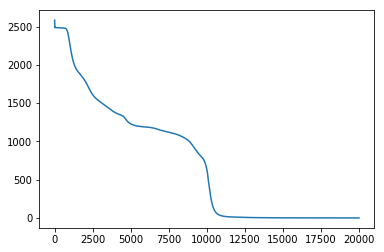

In [18]:
plt.plot(range(iter_count), losses)

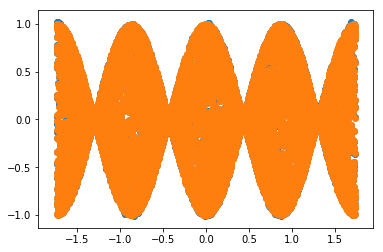

In [19]:
#This is a sanity check to see that our Z_pred values approximately match our actual Z value in one dimension (you can also check the Y dimension)

X_init = phi[:, 0]
plt.scatter(X_init, Z_pred.detach().numpy())
plt.scatter(X_init, Z)